In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.set()
from sklearn.linear_model import SGDClassifier 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import *
import time

%matplotlib inline

In [2]:
#This loop only using all the possible data
df = pd.read_csv('final_data.csv')

In [3]:
df["booking_date"].max()

'2016-04-30 00:00:00'

In [4]:
df.shape

(24855, 27)

In [5]:
acs =pd.read_csv('fips_acs.csv')

In [6]:
acs.columns

Index(['fips', 'per_capita_income', 'poverty_stat', 'household_income',
       'mortgage_stat', 'school_enrollment_16-19', 'own_children_under18',
       'SSI_income', 'grandparent_care', 'military_service', 'education_25',
       'property_value_occupied', 'retirement_income', 'rent_over_income',
       'zip'],
      dtype='object')

In [7]:
df.zip.nunique()

1208

In [8]:
acs.zip.nunique()

244

In [9]:
df=df.dropna(subset=['zip'])

In [10]:
df = acs.merge(df, how="inner")

In [11]:
df.shape

(22923, 41)

In [12]:
df.columns

Index(['fips', 'per_capita_income', 'poverty_stat', 'household_income',
       'mortgage_stat', 'school_enrollment_16-19', 'own_children_under18',
       'SSI_income', 'grandparent_care', 'military_service', 'education_25',
       'property_value_occupied', 'retirement_income', 'rent_over_income',
       'zip', 'mni_no', 'dedupe_id', 'dob', 'sex', 'race', 'mar_stat', 'city',
       'state', 'case_no', 'case_type', 'booking_no', 'arresting_agency',
       'arresting_agency_type', 'booking_date', 'release_date', 'bail_type',
       'bail_amt', 'bailed_out', 'pri_dx_value', 'refferal_source',
       'mh_treatment', 're_entry', 'age', 'after_released', 'within_one',
       'within_two'],
      dtype='object')

In [13]:
#Check the prob of re-entry within one year
df['within_one'].sum()/df.shape[0]

0.2261047855865288

In [14]:
#Check the prob of re-entry within two year
df['within_two'].sum()/df.shape[0]

0.281158661606247

In [15]:
df = df.drop(['re_entry', 'age', 'mni_no', 'dedupe_id', 'dob', 'state', 'city', 'fips', 'zip', 'release_date', 'case_no', 'booking_no', 'pri_dx_value',
       'refferal_source'], axis=1)

In [16]:
df.columns

Index(['per_capita_income', 'poverty_stat', 'household_income',
       'mortgage_stat', 'school_enrollment_16-19', 'own_children_under18',
       'SSI_income', 'grandparent_care', 'military_service', 'education_25',
       'property_value_occupied', 'retirement_income', 'rent_over_income',
       'sex', 'race', 'mar_stat', 'case_type', 'arresting_agency',
       'arresting_agency_type', 'booking_date', 'bail_type', 'bail_amt',
       'bailed_out', 'mh_treatment', 'after_released', 'within_one',
       'within_two'],
      dtype='object')

In [17]:
df.head()

per_capita_income  poverty_stat  household_income  mortgage_stat  \
0            26836.0          1118               456            364   
1            26836.0          1118               456            364   
2            26836.0          1118               456            364   
3            26836.0          1118               456            364   
4            26836.0          1118               456            364   

   school_enrollment_16-19  own_children_under18  SSI_income  \
0                      167                   175         456   
1                      167                   175         456   
2                      167                   175         456   
3                      167                   175         456   
4                      167                   175         456   

   grandparent_care  military_service  education_25    ...      \
0               692                66           776    ...       
1               692                66           776    ...       
2               692                66           776    ...       
3               692                66           776    ...       
4               692                66           776    ...       

                      arresting_agency  arresting_agency_type  \
0  JOHNSON COUNTY SHERIFF'S DEPARTMENT         COUNTY SHERIFF   
1  JOHNSON COUNTY SHERIFF'S DEPARTMENT         COUNTY SHERIFF   
2                   OVERLAND PARK P.D.                   CITY   
3  JOHNSON COUNTY SHERIFF'S DEPARTMENT         COUNTY SHERIFF   
4  JOHNSON COUNTY SHERIFF'S DEPARTMENT         COUNTY SHERIFF   

          booking_date bail_type bail_amt bailed_out mh_treatment  \
0  2013-12-30 00:00:00       SUR   1500.0          1            0   
1  2013-11-10 00:00:00       SUR  15000.0          1            1   
2  2012-10-10 00:00:00       SUR  20000.0          1            1   
3  2011-05-26 00:00:00       SUR   5000.0          1            1   
4  2011-06-27 00:00:00       SUR   5000.0          1            1   

  after_released within_one within_two  
0          586.0          0          1  
1          603.0          0          1  
2          -41.0          1          1  
3            7.0          1          1  
4           32.0          1          1  

[5 rows x 27 columns]

In [18]:
dummy_vals = ['sex', 'race','mar_stat', 'case_type', 'arresting_agency', 'arresting_agency_type', 'bail_type' ]

In [19]:
#generate dummy variable for specific column
def getting_dummy(df, col):
    '''
    Helper function to create dummy variables in dataframe for specific column
    This function will return dataframe
    '''
    dummies = pd.get_dummies(df[col]).rename(columns=lambda x: str(col)+ str(x))
    df = pd.concat([df, dummies], axis=1)
    df.drop([col], inplace=True, axis=1)
    return df

In [20]:
for dummy in dummy_vals:
    df = getting_dummy(df, dummy)

In [21]:
#4 GenerateFeatures/Predictors: discretize a continuous variable 
def discrete_val(df, cols, bins=4):
    '''
    Helper function to discrete the continueous variable in dataframe into 4 bins
    This function will return dictionary mapping column name to the bin values
    '''
    for col in cols:
        new = col+'_binned'
        df[new] = pd.cut(df[col], bins, include_lowest=True, labels = range(0,bins))
        df.drop([col], inplace=True, axis=1)
    return df

In [22]:
binv = ['per_capita_income', 'poverty_stat', 'household_income',
       'mortgage_stat', 'school_enrollment_16-19', 'own_children_under18',
       'SSI_income', 'grandparent_care', 'military_service', 'education_25',
       'property_value_occupied', 'retirement_income', 'rent_over_income','bail_amt']
df = discrete_val(df, binv, 6)

In [23]:
dum = [ 'per_capita_income_binned',
 'poverty_stat_binned',
 'household_income_binned',
 'mortgage_stat_binned',
 'school_enrollment_16-19_binned',
 'own_children_under18_binned',
 'SSI_income_binned',
 'grandparent_care_binned',
 'military_service_binned',
 'education_25_binned',
 'property_value_occupied_binned',
 'retirement_income_binned',
 'rent_over_income_binned',
 'bail_amt_binned']

In [24]:
for dummy in dum:
    df = getting_dummy(df, dummy)

In [25]:
indepv = list(df.columns)

In [26]:
indepv.remove('after_released')

In [27]:
indepv.remove('within_one')

In [28]:
indepv.remove('within_two')

In [29]:
indepv

['booking_date',
 'bailed_out',
 'mh_treatment',
 'sexFEMALE',
 'sexMALE',
 'raceAMERICAN INDIAN OR ALASKA NATIVE',
 'raceASIAN',
 'raceBLACK OR AFRICAN AMERICAN',
 'raceWHITE',
 'mar_statA',
 'mar_statD',
 'mar_statM',
 'mar_statN',
 'mar_statS',
 'mar_statU',
 'mar_statW',
 'mar_statY',
 'case_typeCR',
 'case_typeDV',
 'case_typeJV',
 'arresting_agencyFAIRWAY P.D.',
 'arresting_agencyGARDNER P.D.',
 'arresting_agencyJOHNSON COUNTY PARK PATROL',
 "arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT",
 'arresting_agencyKANSAS HIGHWAY PATROL',
 'arresting_agencyLAKE QUIVIRA P.D.',
 'arresting_agencyLEAWOOD P.D.',
 'arresting_agencyLENEXA P.D.',
 'arresting_agencyMERRIAM P.D.',
 'arresting_agencyMISSION P.D.',
 'arresting_agencyOLATHE P.D.',
 'arresting_agencyOTHER AGENCY',
 'arresting_agencyOVERLAND PARK P.D.',
 'arresting_agencyPRAIRIE VILLAGE P.D.',
 'arresting_agencyROELAND PARK P.D.',
 'arresting_agencySHAWNEE MISSION SCHOOL SECURITY',
 'arresting_agencySHAWNEE P.D.',
 'arresting_ag

In [30]:
def temporal_split(df, time_col, start_time, mid_time, end_time):
    train = df[(df[time_col] >= start_time) & (df[time_col] < mid_time) ]
    test = df[(df[time_col] >= mid_time)  & (df[time_col] < end_time)]
    train = train.drop([time_col], axis=1)
    test = test.drop([time_col], axis=1)
    return train, test

In [31]:
indepv.remove('booking_date')

In [32]:
def split_data(train, test, y):
    '''
    Split the data into training and testing set
    
    And save them to run try different models
    '''
    x_test = test[indepv] 
    x_train = train[indepv]
    y_test = test[y]
    y_train = train[y]
    
    return x_train, x_test, y_train, y_test

In [33]:
train, test = temporal_split(df, 'booking_date', '2010-01-01', '2015-07-01', '2018-01-01' )

In [34]:
train.shape

(19516, 136)

In [35]:
test.shape

(3407, 136)

In [36]:
clfs = {'RF': RandomForestClassifier(),
    'Boost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)),
    'Logit': LogisticRegression(),
    'SVM': SVC(probability=True, random_state=0),
    'Tree': DecisionTreeClassifier(),
    'Bag': BaggingClassifier(),
    'KNN': KNeighborsClassifier(),
    'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
    'NB': GaussianNB()}

small_grid = {'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'Boost': {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000]},
    'Logit': {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10]},
    'SVM' :{'C' :[0.01,0.1,1,10],'kernel':['linear']},
    'Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [5,10,20,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5]},
    'Bag':{'n_estimators':[1,10,20,50], 'max_samples':[5,10], 'max_features': [5,10]},
    'KNN' :{'n_neighbors': [1,10,50],'weights': ['uniform','distance'],'algorithm': ['auto']},
    'ET': {'n_estimators': [10,100], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'NB' : {}}

In [37]:
def generate_binary_at_k(y_scores, k):
    '''
    Set first k% as 1, the rest as 0.
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

In [38]:
def scores_at_k(y_true, y_scores, k):
    '''
    For a given level of k, calculate corresponding
    precision, recall, and f1 scores.
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = round(precision_score(y_true, preds_at_k),4)
    recall = round(recall_score(y_true, preds_at_k), 4)
    f1 = round(f1_score(y_true, preds_at_k),4)
    return precision, recall, f1

In [40]:
def plot(y_test, y_pred_probs, model, para = None):

    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for {} model: AUC={:.2f} \n with parameters: {}'.\
                        format(model, average_precision_score(y_test, y_pred_probs), para))
    plt.show()

In [41]:
def clf_loop(models, x_train, x_test, y_train, y_test, grid=small_grid):
    '''
    Run model with given params on x and y
    and print out the scores for comparison
    '''
    results_df = pd.DataFrame(columns=('model_type', 'parameters', 'accuracy','auc-roc', 'precision', 'time', 'precision,recall,f1 at_5',
     'precision,recall,f1 at_10', 'precision,recall,f1 at_20', 'precision,recall,f1 at_30', 'precision,recall,f1 at_50'))
    for index, clf in enumerate([clfs[x] for x in models]):
        model_params = grid[models[index]]
        for p in ParameterGrid(model_params):
            try:
                start = time.time()
                clf.set_params(**p)
                y_pred_probs = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
                accuracy = clf.score(x_test, y_test)
                end = time.time()
                #Zip, unzip to ensure corresponding order
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))

                results_df.loc[len(results_df)] = [models[index], p, round(accuracy, 4),
                                             round(roc_auc_score(y_test, y_pred_probs),4),
                                             round(average_precision_score(y_test, y_pred_probs),4),
                                             round(end-start, 4) ,                                                    
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,30.0),
                                             scores_at_k(y_test_sorted,y_pred_probs_sorted,50.0)]

                plot(y_test, y_pred_probs, models[index],p)
                
            except IndexError as e:
                print(e)
                continue
    return results_df

In [42]:
#Running classifiers to predict if the person re-enter within one years
x_train, x_test, y_train, y_test = split_data(train, test, 'within_one')

In [43]:
x_train, x_test, y_train2, y_test2 = split_data(train, test, 'within_two')

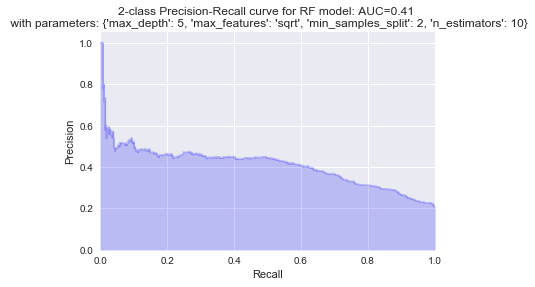

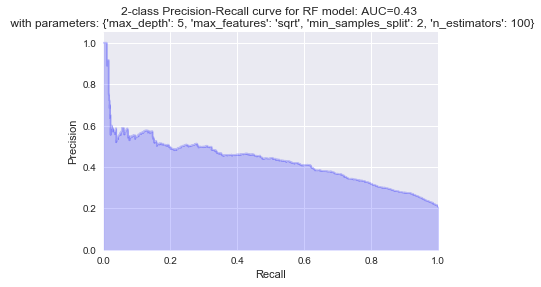

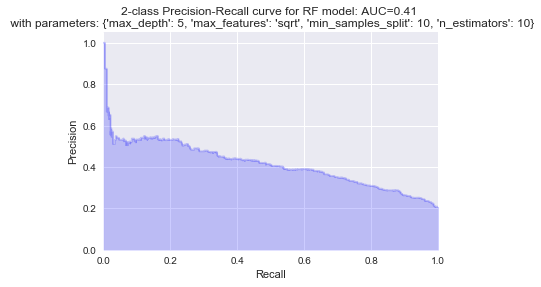

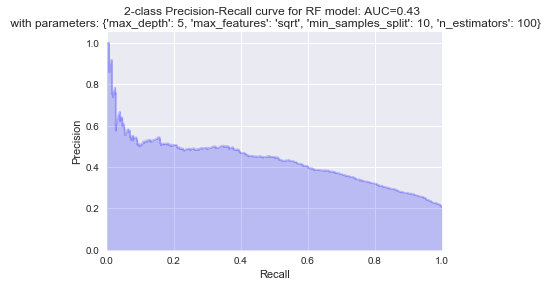

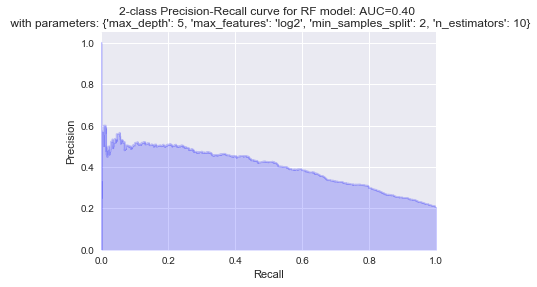

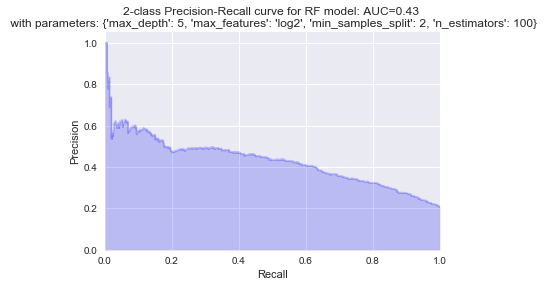

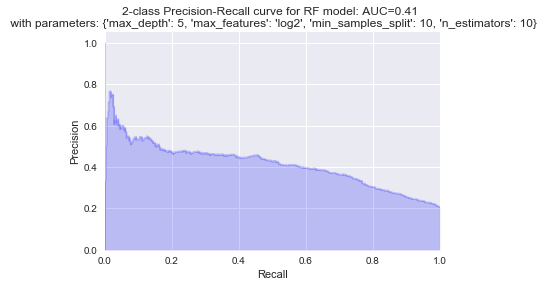

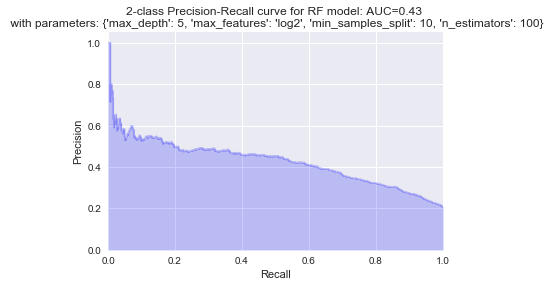

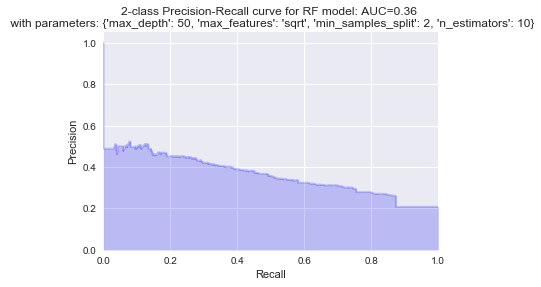

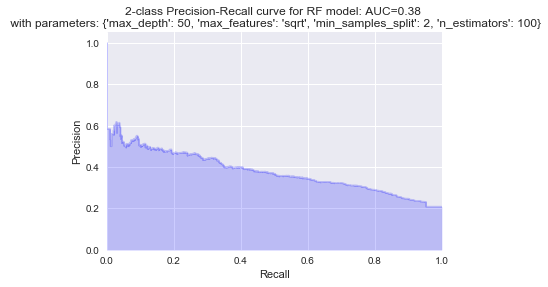

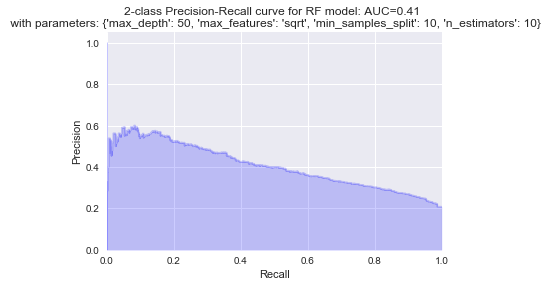

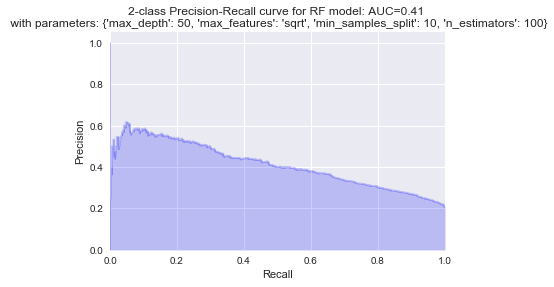

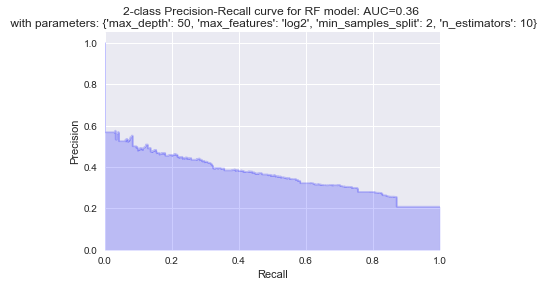

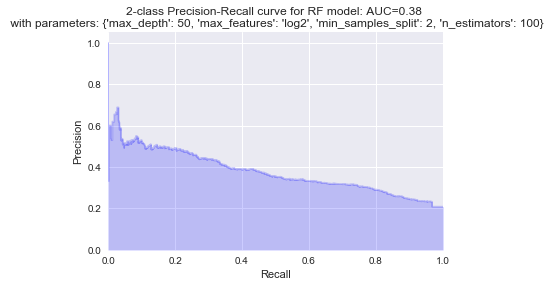

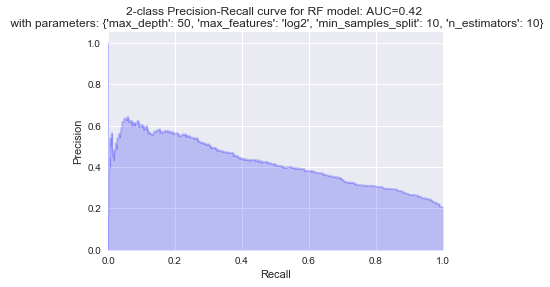

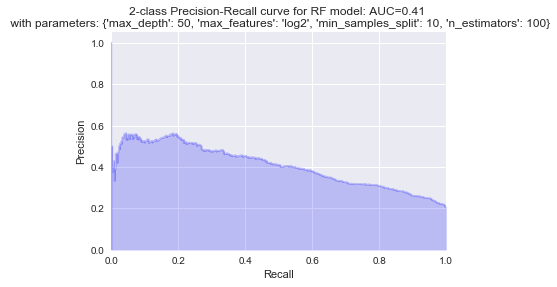

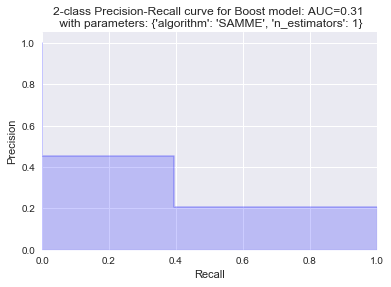

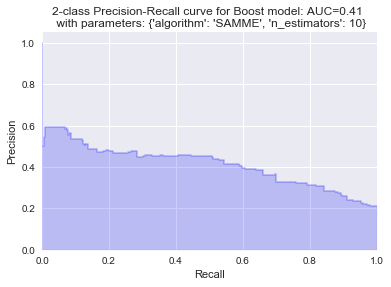

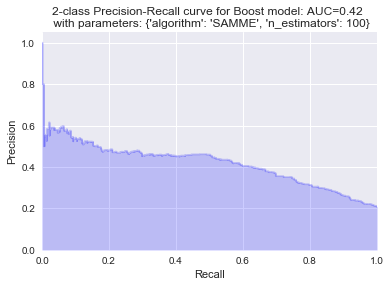

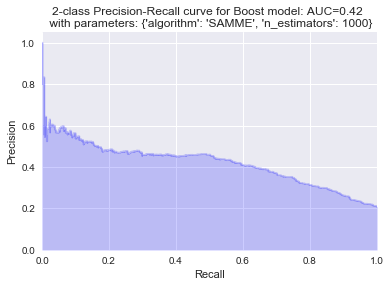

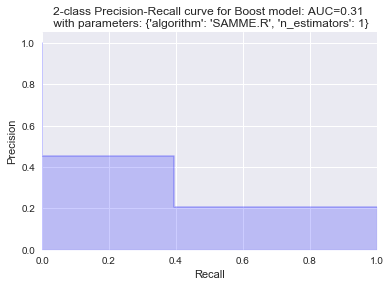

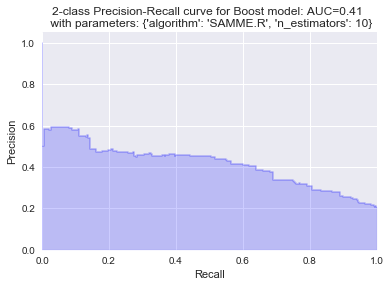

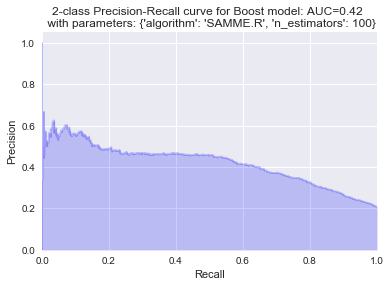

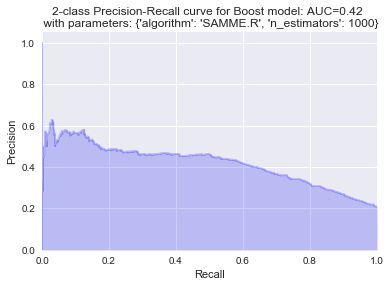

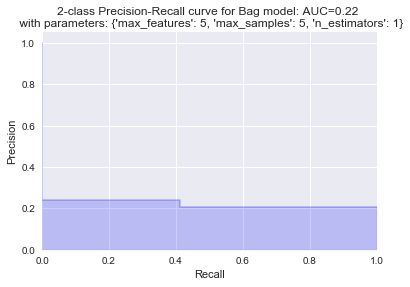

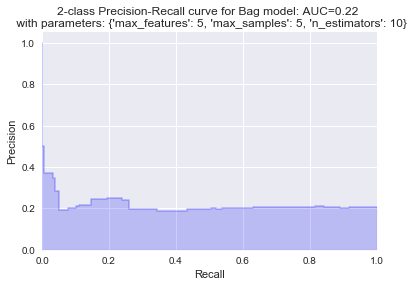

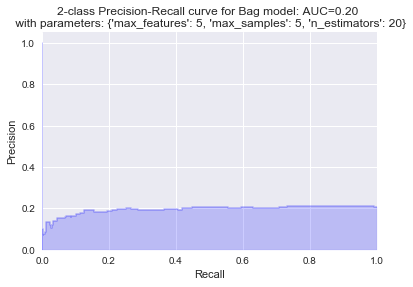

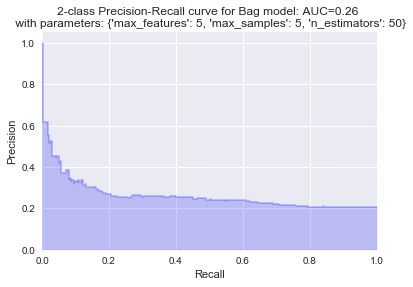

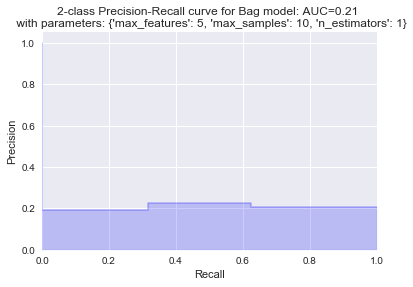

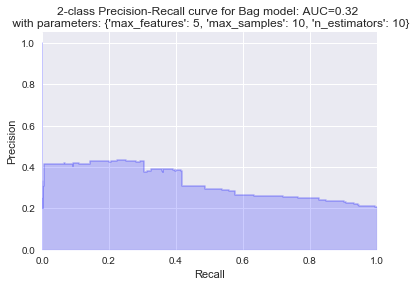

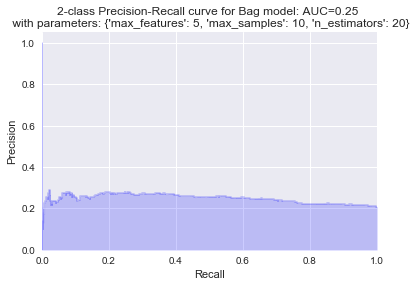

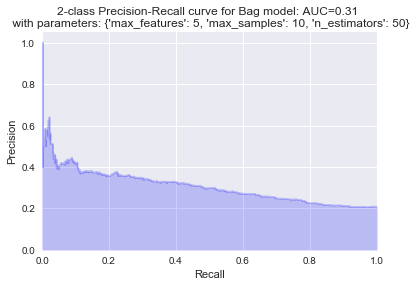

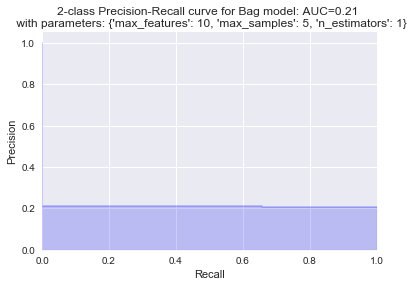

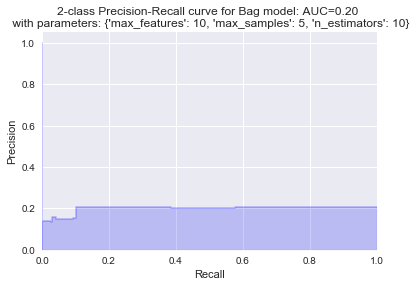

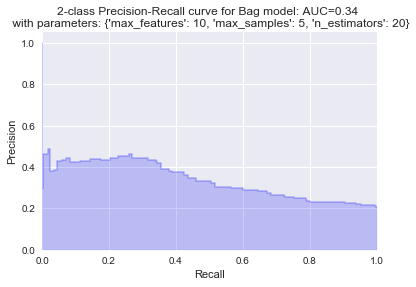

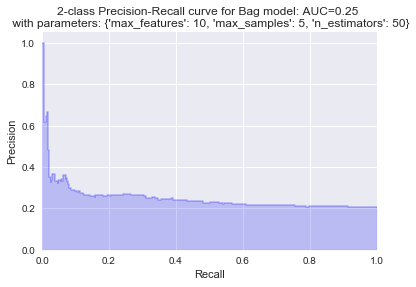

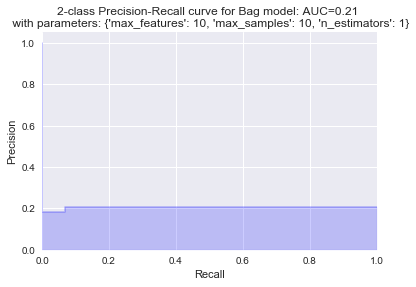

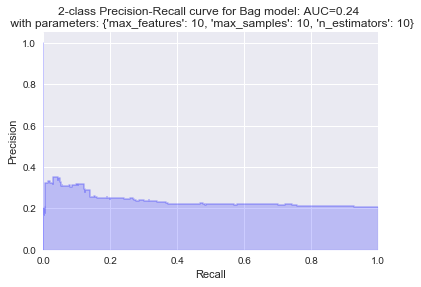

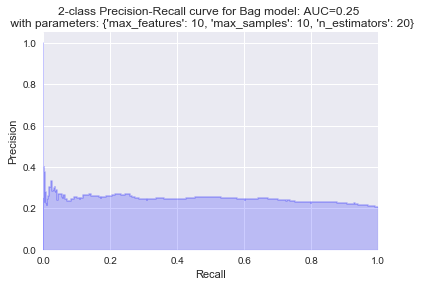

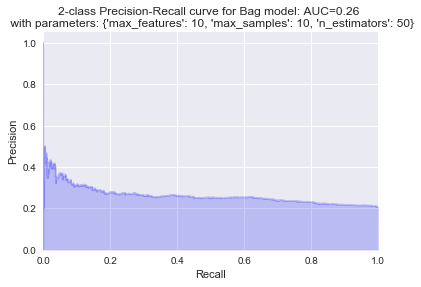

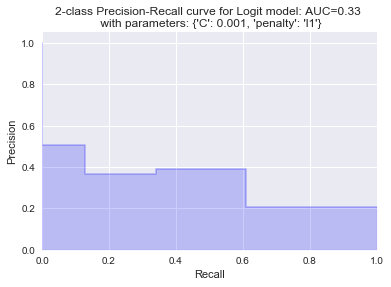

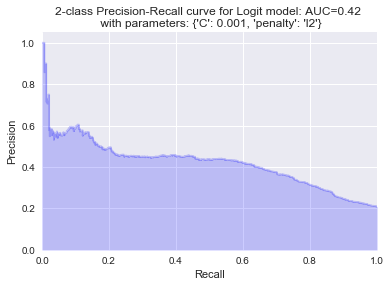

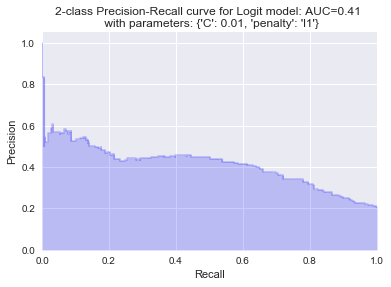

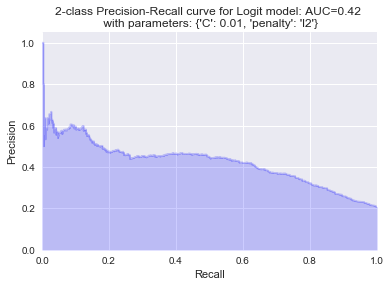

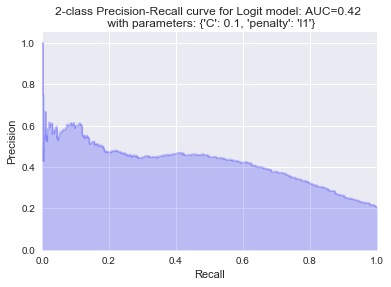

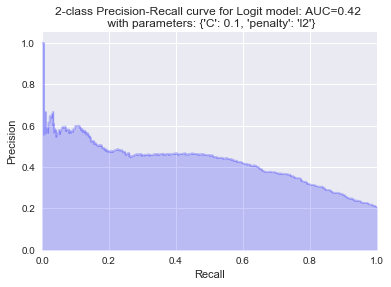

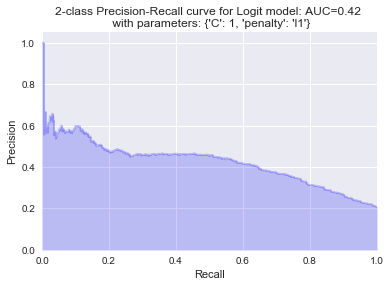

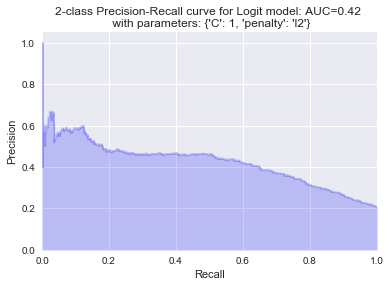

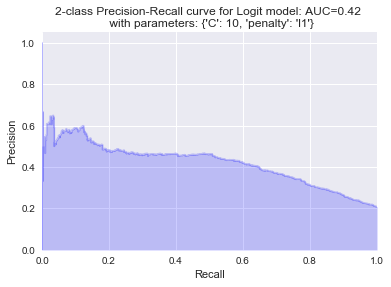

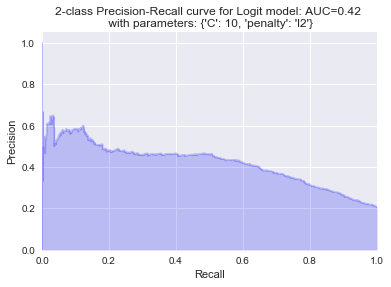

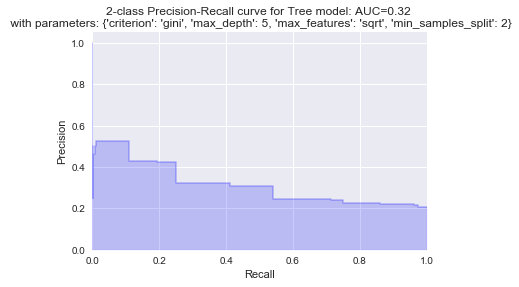

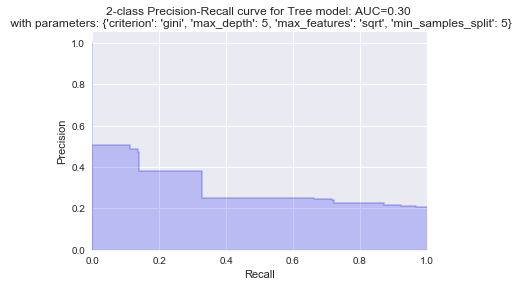

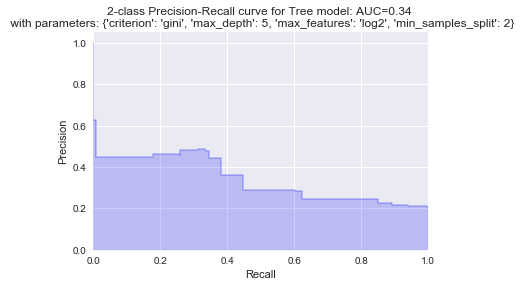

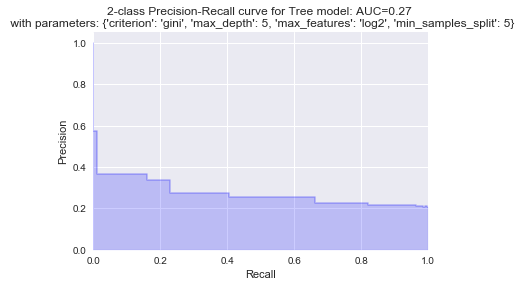

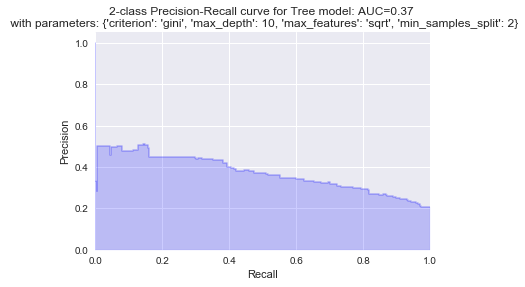

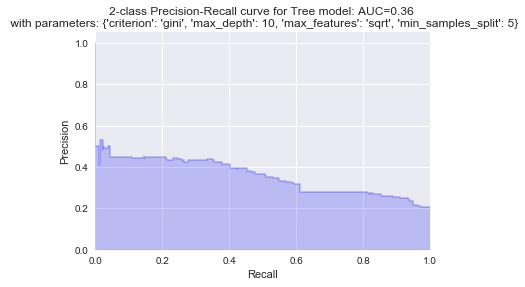

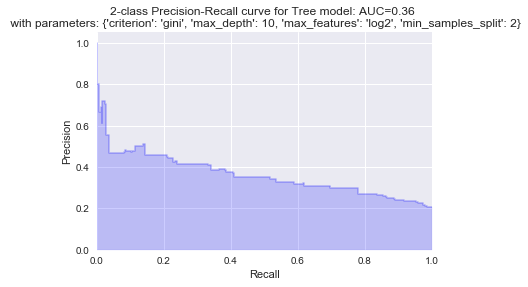

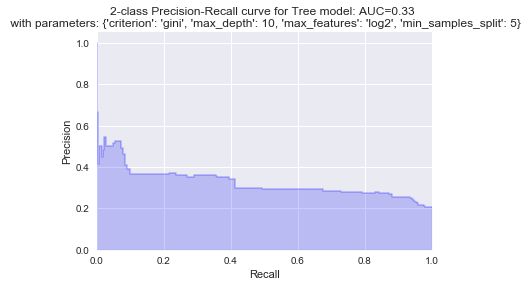

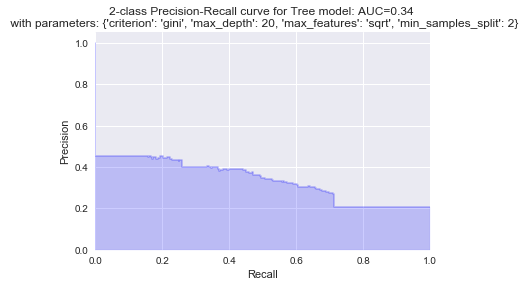

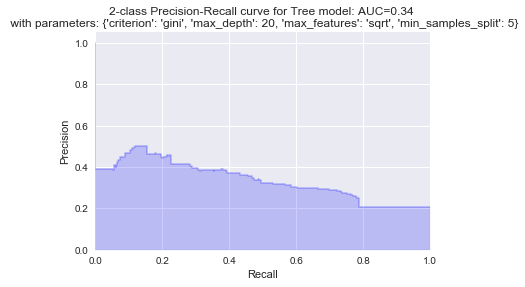

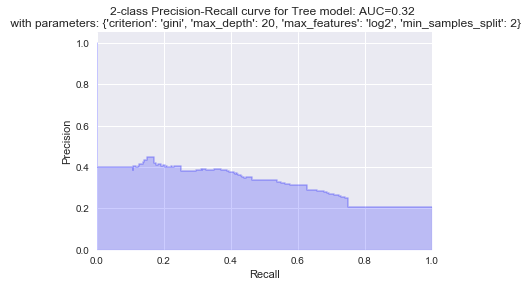

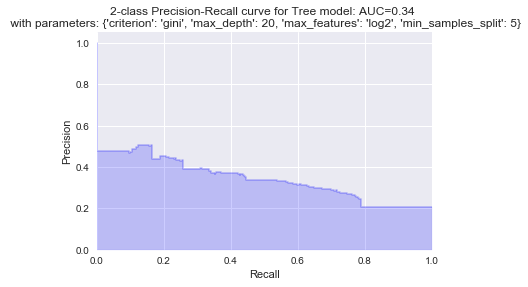

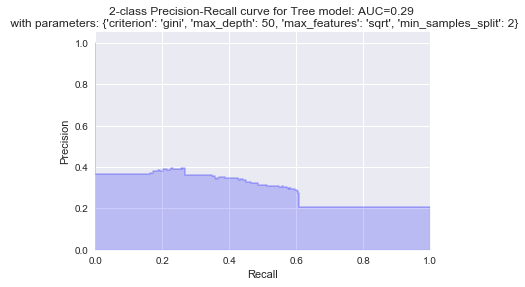

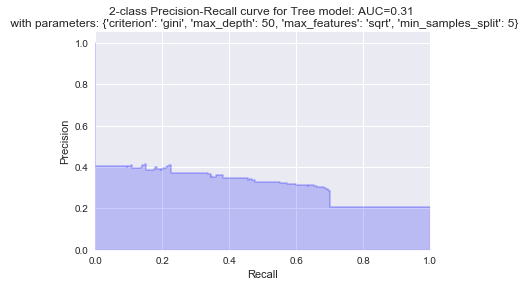

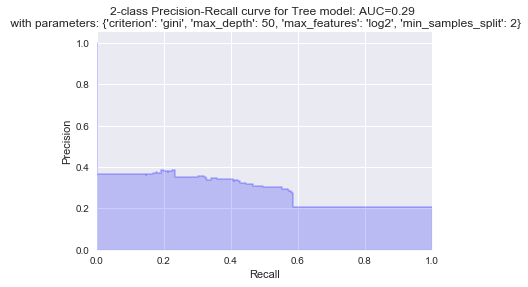

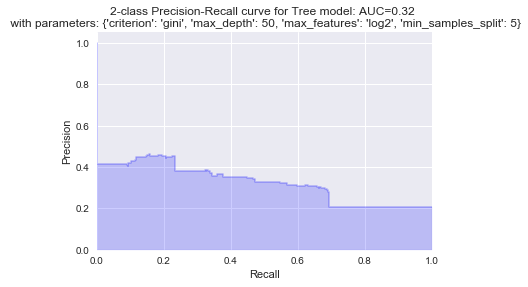

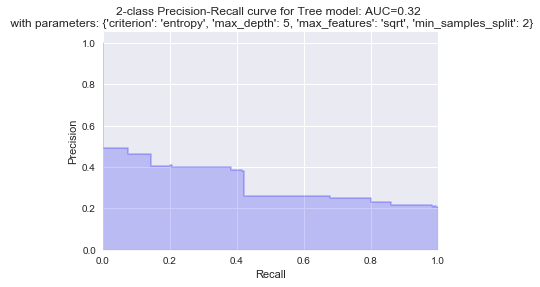

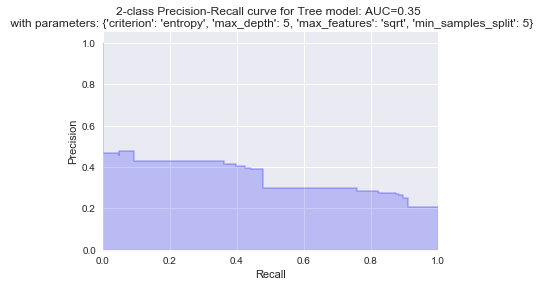

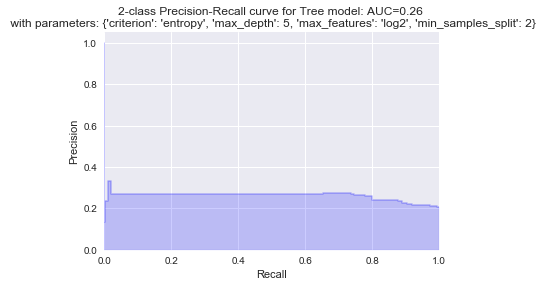

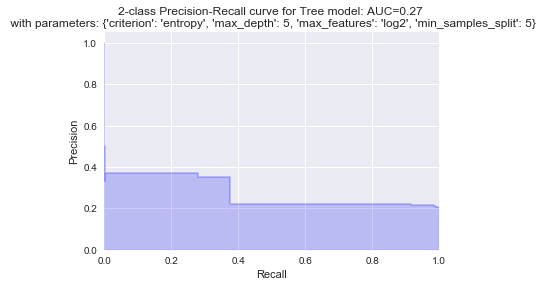

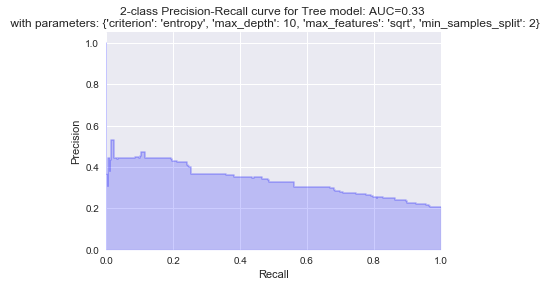

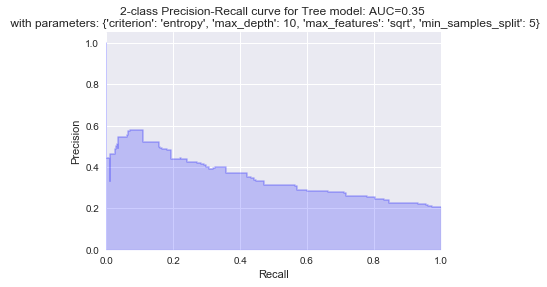

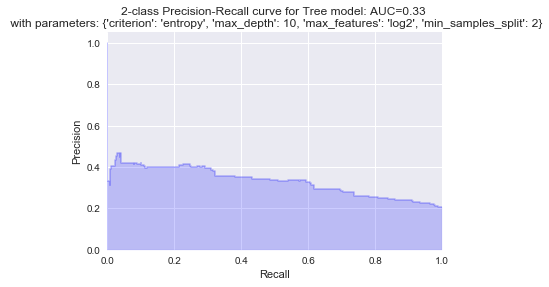

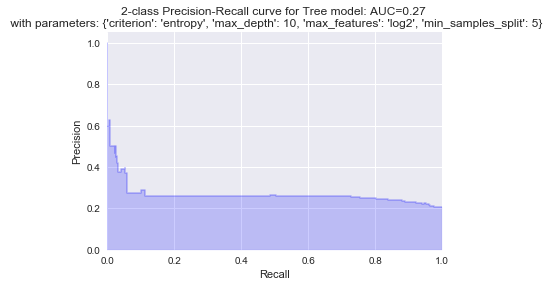

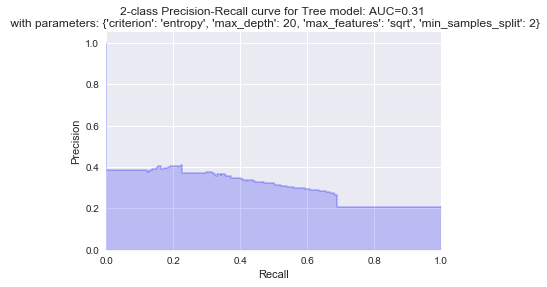

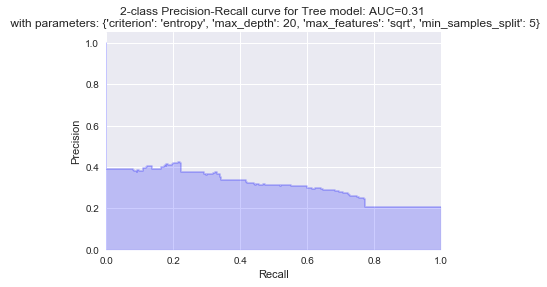

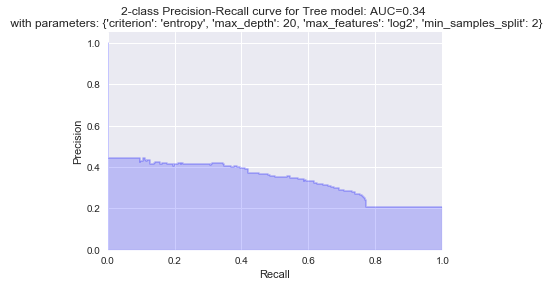

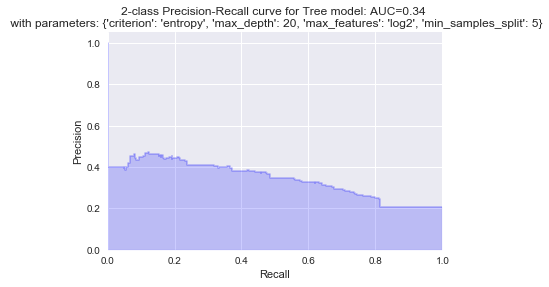

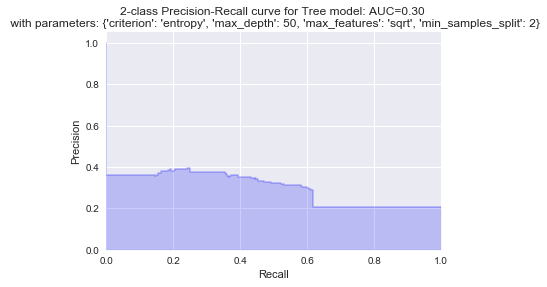

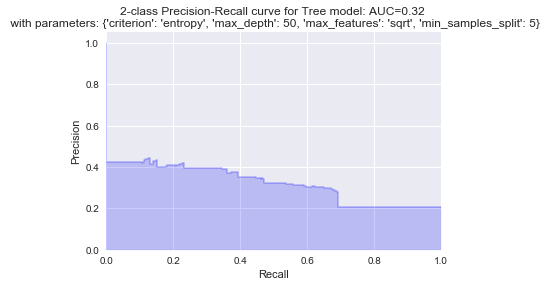

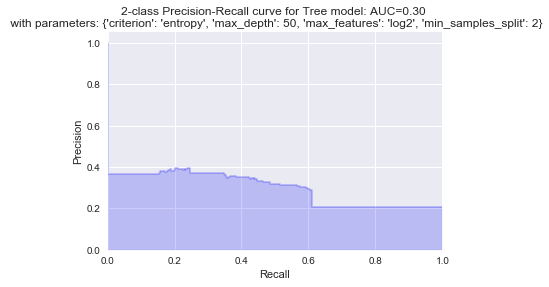

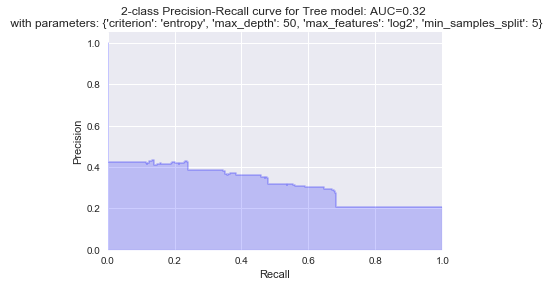

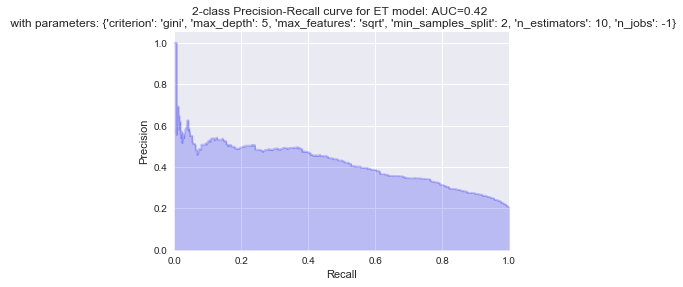

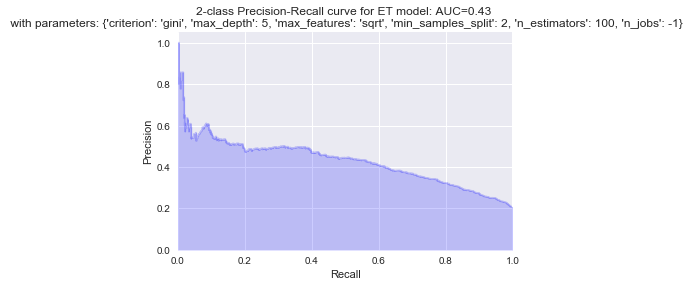

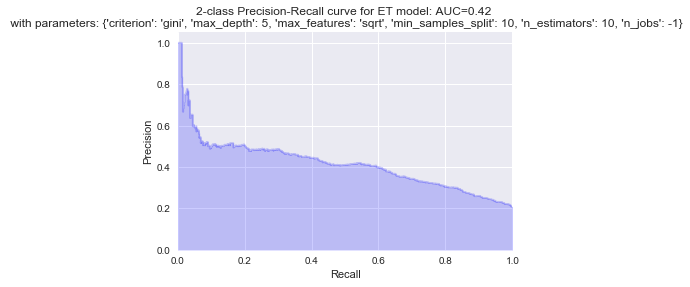

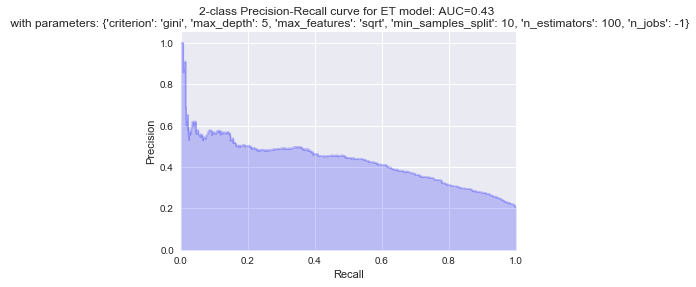

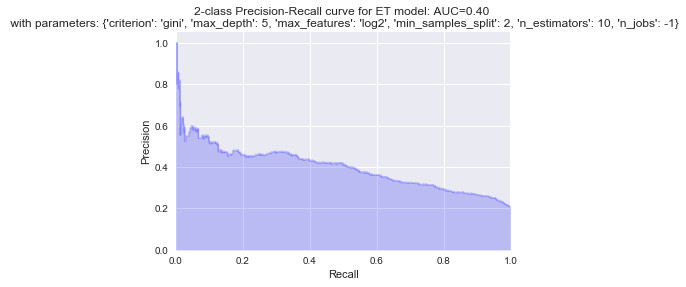

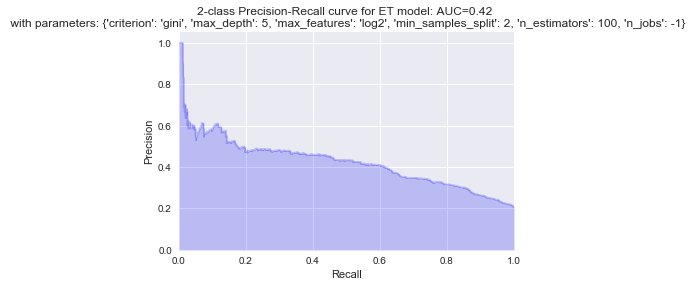

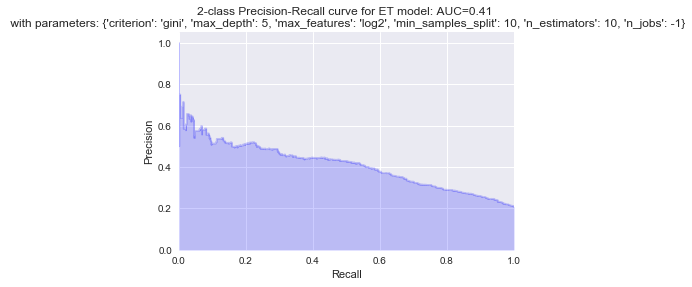

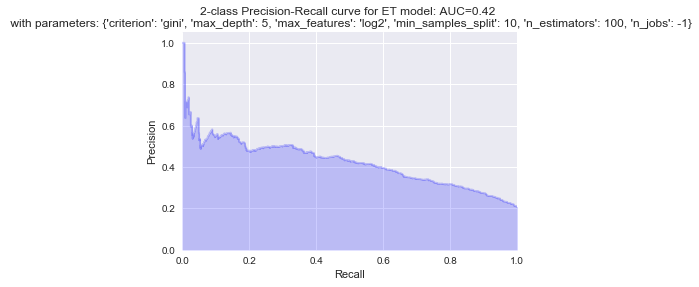

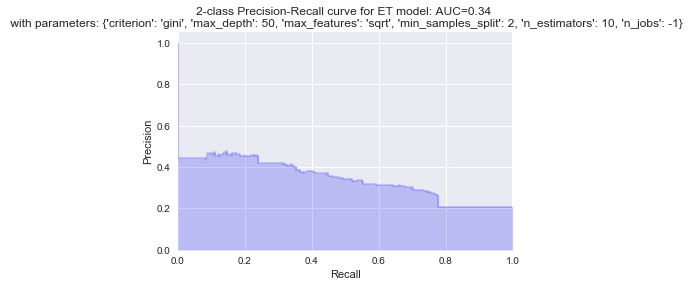

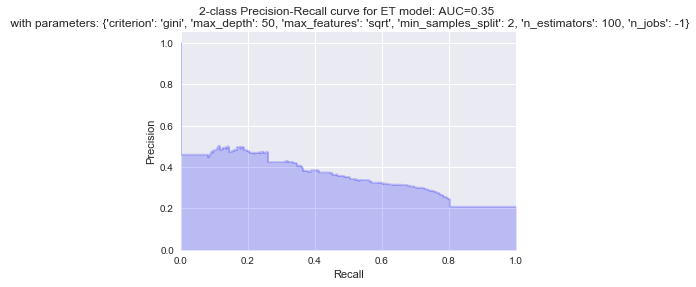

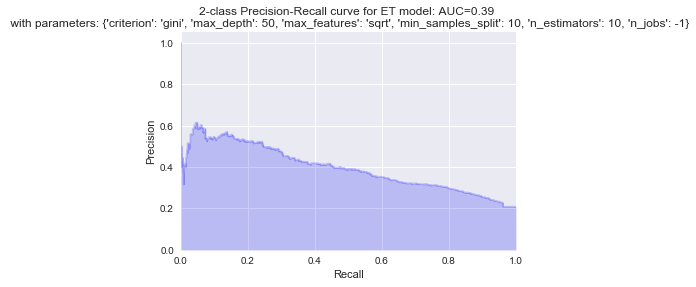

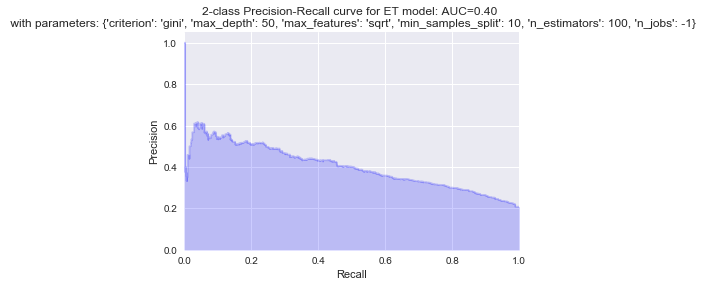

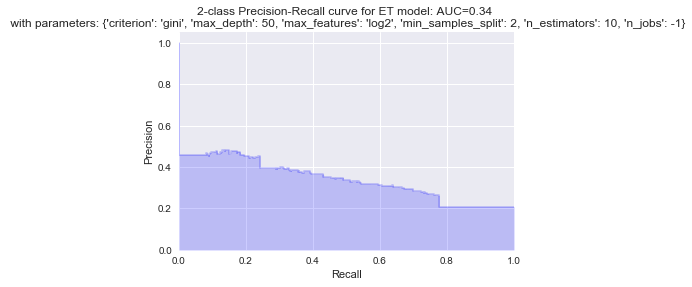

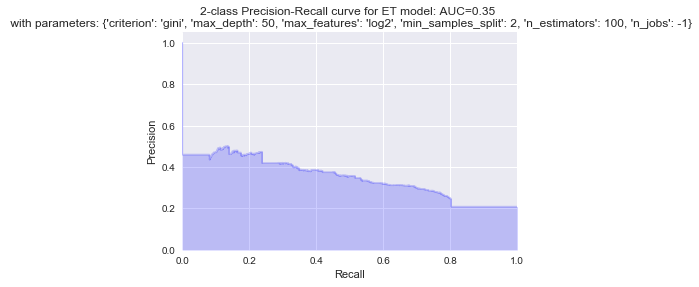

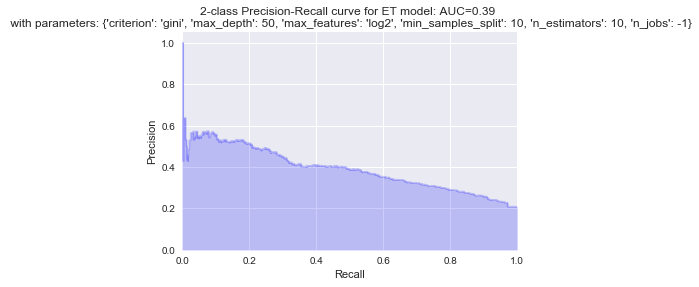

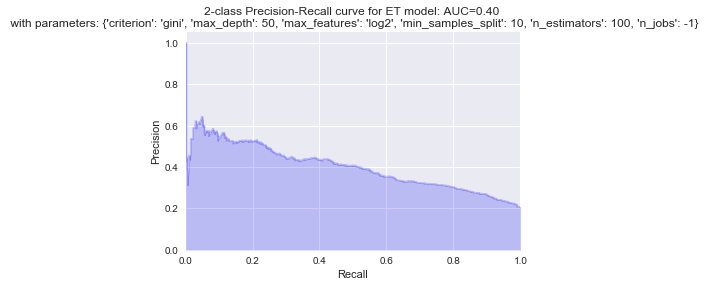

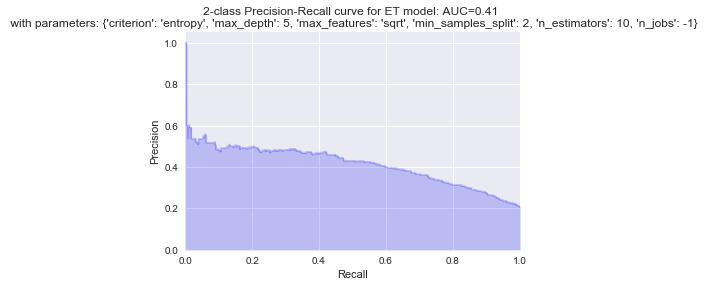

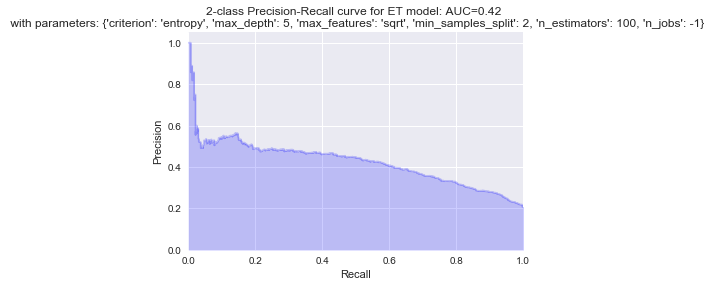

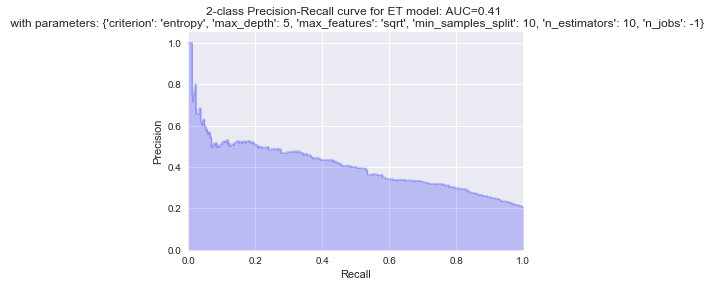

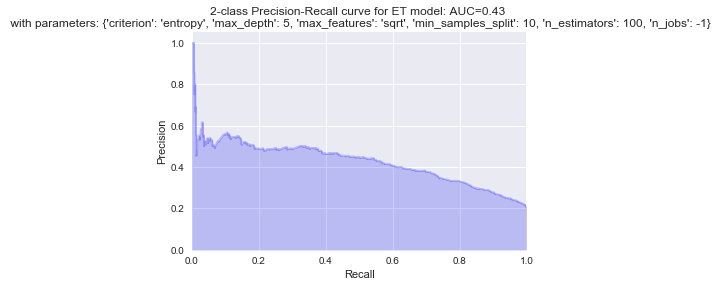

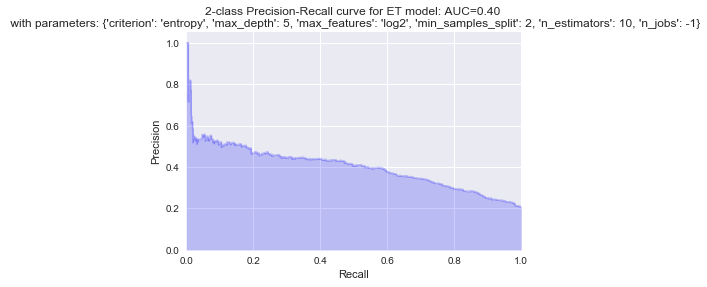

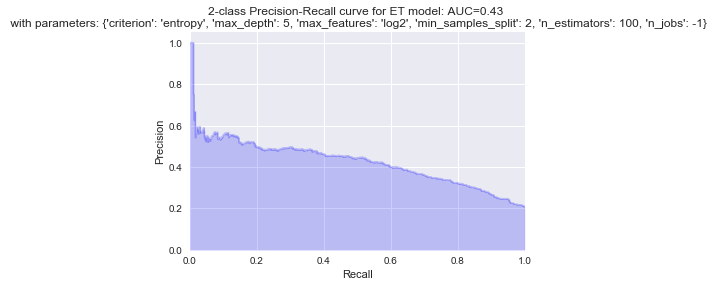

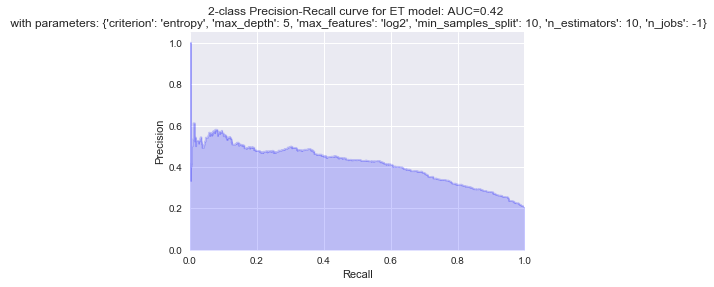

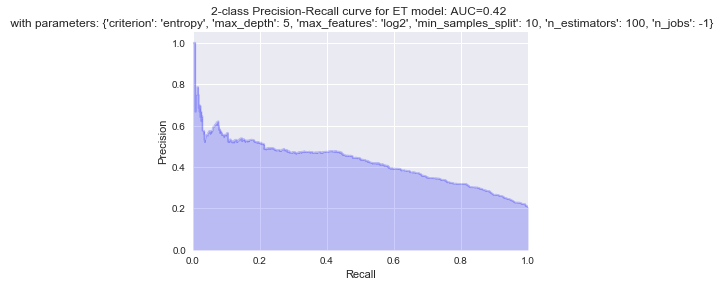

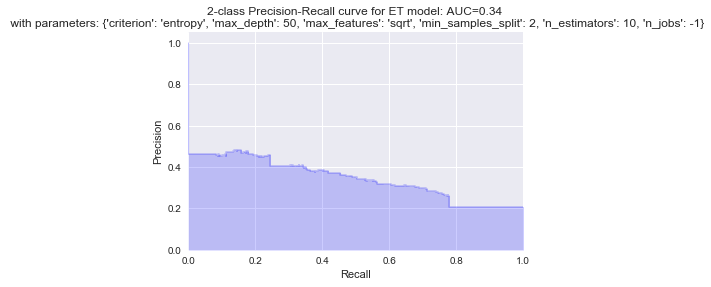

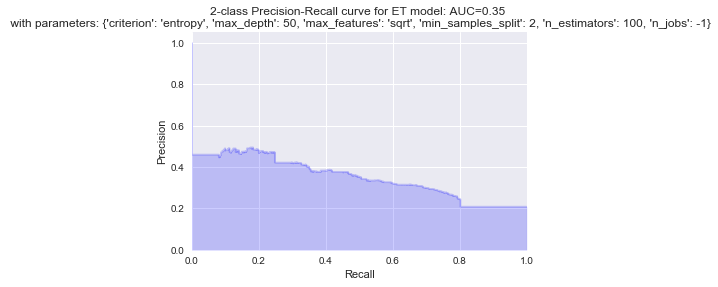

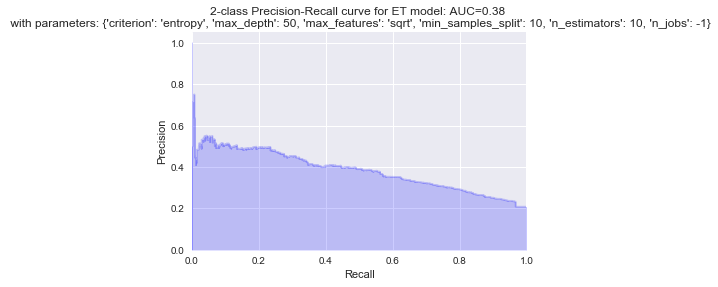

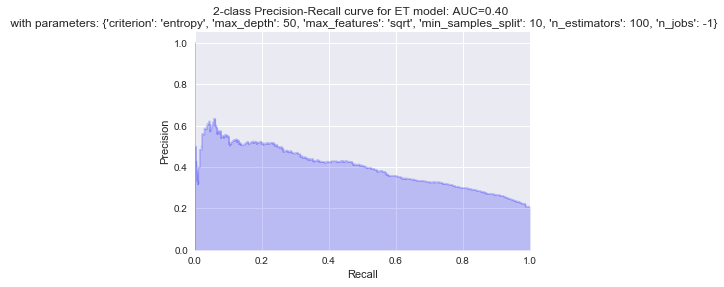

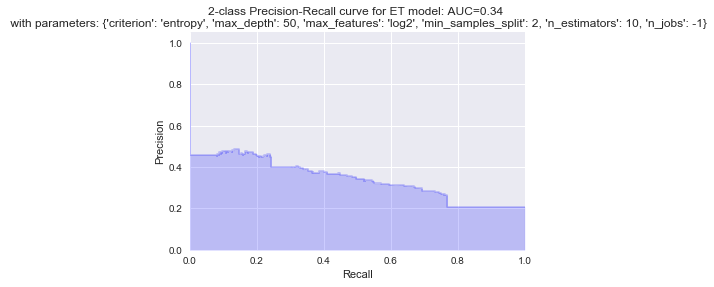

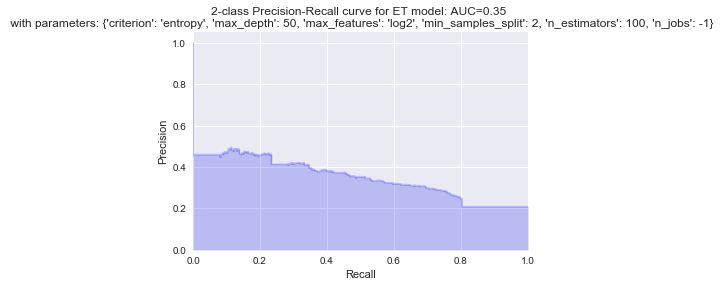

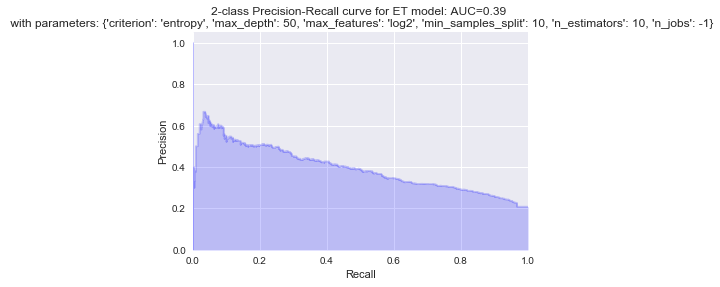

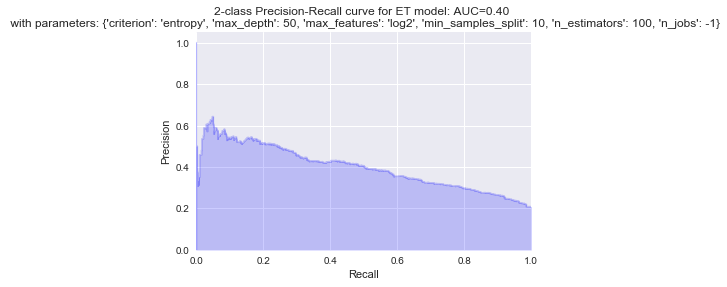

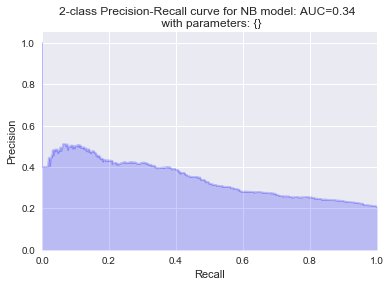

In [44]:
results = clf_loop(["RF", "Boost", "Bag", "Logit", "Tree",  "ET", "NB"], x_train, x_test, y_train, y_test)

In [45]:
from IPython.display import display
display(results)

model_type                                         parameters  accuracy  \
0           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7937   
1           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7934   
2           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7928   
3           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7934   
4           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...    0.7919   
5           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...    0.7919   
6           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...    0.7913   
7           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...    0.7919   
8           RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...    0.7766   
9           RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...    0.7822   
10          RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...    0.7934   
11          RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...    0.7951   
12          RF  {'max_depth': 50, 'max_features': 'log2', 'min...    0.7766   
13          RF  {'max_depth': 50, 'max_features': 'log2', 'min...    0.7816   
14          RF  {'max_depth': 50, 'max_features': 'log2', 'min...    0.7998   
15          RF  {'max_depth': 50, 'max_features': 'log2', 'min...    0.7969   
16       Boost          {'algorithm': 'SAMME', 'n_estimators': 1}    0.7755   
17       Boost         {'algorithm': 'SAMME', 'n_estimators': 10}    0.7857   
18       Boost        {'algorithm': 'SAMME', 'n_estimators': 100}    0.7840   
19       Boost       {'algorithm': 'SAMME', 'n_estimators': 1000}    0.7869   
20       Boost        {'algorithm': 'SAMME.R', 'n_estimators': 1}    0.7755   
21       Boost       {'algorithm': 'SAMME.R', 'n_estimators': 10}    0.7846   
22       Boost      {'algorithm': 'SAMME.R', 'n_estimators': 100}    0.7849   
23       Boost     {'algorithm': 'SAMME.R', 'n_estimators': 1000}    0.7857   
24         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...    0.6102   
25         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...    0.7849   
26         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...    0.7919   
27         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...    0.7919   
28         Bag  {'max_features': 5, 'max_samples': 10, 'n_esti...    0.7919   
29         Bag  {'max_features': 5, 'max_samples': 10, 'n_esti...    0.7904   
..         ...                                                ...       ...   
85          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7928   
86          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7919   
87          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7919   
88          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7919   
89          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7919   
90          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7816   
91          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7857   
92          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7922   
93          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7922   
94          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7810   
95          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7860   
96          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7904   
97          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7940   
98          ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7925   
99          ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7931   
100         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7937   
101         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7934   
102         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7928   
103         ET  {'criterion': 'entropy', 'max_depth': 

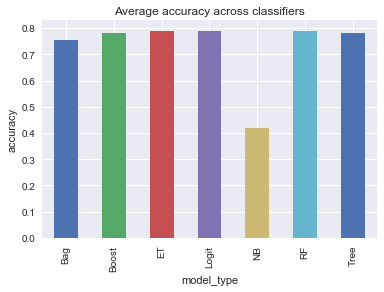

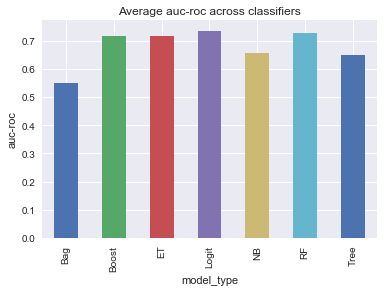

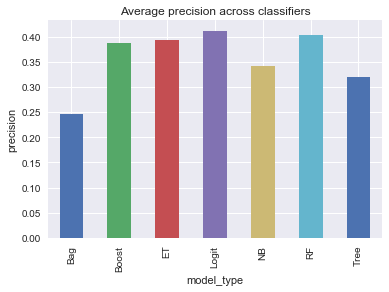

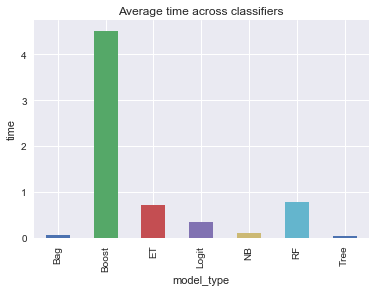

In [49]:
for item in ['accuracy', 'auc-roc','precision','time']:
    plt.figure()
    results.groupby(['model_type'])[item].mean().plot(kind='bar', title='Average '+item+' across classifiers')
    plt.ylabel(item)

In [79]:
best =results.groupby('model_type')['auc-roc'].nlargest(1)
best

model_type     
Bag         34     0.6563
Boost       22     0.7463
ET          101    0.7524
Logit       44     0.7446
NB          114    0.6560
RF          1      0.7490
Tree        54     0.7065
Name: auc-roc, dtype: float64

In [84]:
rows = [34,22,101,44,114,1,54]

In [85]:
results.loc[rows].iloc[:,0:6]

model_type                                         parameters  accuracy  \
34         Bag  {'max_features': 10, 'max_samples': 5, 'n_esti...    0.7919   
22       Boost      {'algorithm': 'SAMME.R', 'n_estimators': 100}    0.7849   
101         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7934   
44       Logit                        {'C': 0.1, 'penalty': 'l1'}    0.7849   
114         NB                                                 {}    0.4183   
1           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7934   
54        Tree  {'criterion': 'gini', 'max_depth': 10, 'max_fe...    0.7784   

     auc-roc  precision    time  
34    0.6563     0.3356  0.0561  
22    0.7463     0.4194  1.6444  
101   0.7524     0.4261  0.6071  
44    0.7446     0.4221  0.1982  
114   0.6560     0.3413  0.1064  
1     0.7490     0.4294  0.6234  
54    0.7065     0.3713  0.0254

In [86]:
best = {}
for row in rows:
    best[results.loc[row]["model_type"]]=results.loc[row]["parameters"]

In [87]:
for k,arg in best.items():
    for key,val in arg.items():
        arg[key] = [val]

In [88]:
for k, arg in best.items():
    print(arg)

{'max_features': [10], 'max_samples': [5], 'n_estimators': [20]}
{'algorithm': ['SAMME.R'], 'n_estimators': [100]}
{'criterion': ['entropy'], 'max_depth': [5], 'max_features': ['sqrt'], 'min_samples_split': [10], 'n_estimators': [100], 'n_jobs': [-1]}
{'C': [0.1], 'penalty': ['l1']}
{}
{'max_depth': [5], 'max_features': ['sqrt'], 'min_samples_split': [2], 'n_estimators': [100]}
{'criterion': ['gini'], 'max_depth': [10], 'max_features': ['sqrt'], 'min_samples_split': [2]}


In [109]:
def plot_best(models, x_train, x_test, y_train, y_test, bestm = best):
    '''
    Run model with the best given params on x and y
    and print out the scores for comparison
    '''
    for index, clf in enumerate([clfs[x] for x in models]):
        model_params = bestm[models[index]]
        for p in ParameterGrid(model_params):
            try:
                clf.set_params(**p)
                y_pred_probs = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
                plot_precision_recall_n(y_test, y_pred_probs, models[index],p)
                
            except IndexError as e:
                print(e)
                continue
    

In [97]:
def plot_precision_recall_n(y_true, y_score, model_name,  para = None, fig =None):
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    
    plt.title('2-class Precision-Recall curve for {} model: AUC={:.2f} \n with parameters: {}'.\
                        format(model_name, average_precision_score(y_true, y_score), para))
    plt.show()
    

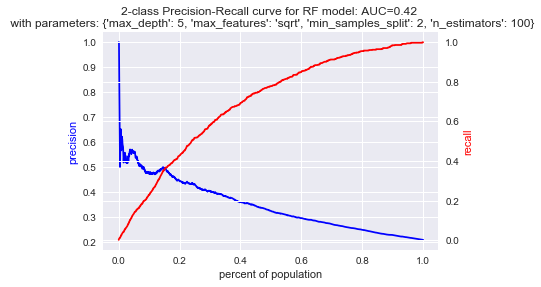

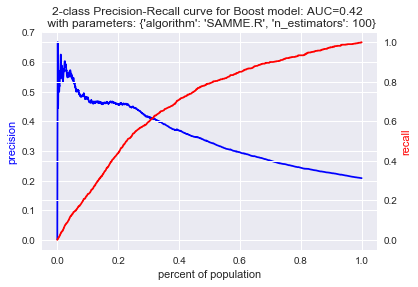

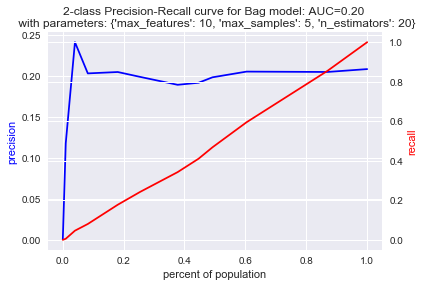

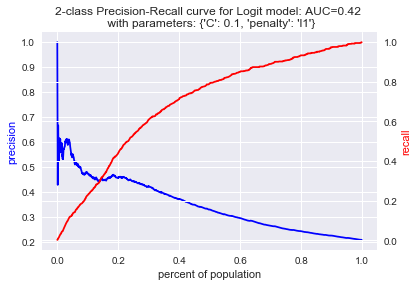

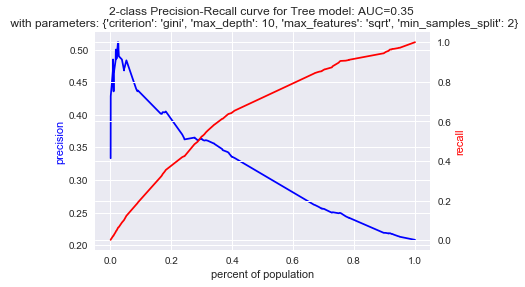

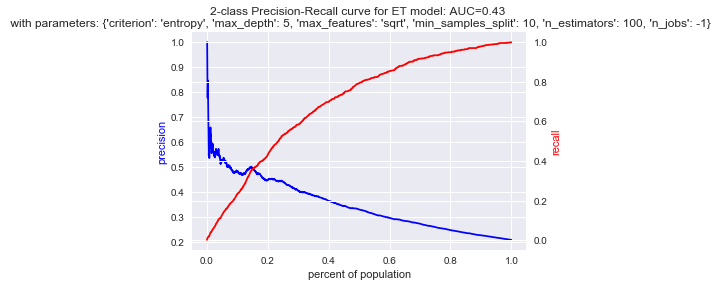

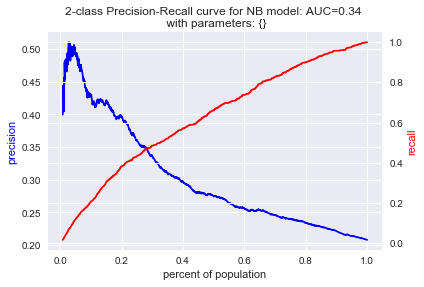

In [98]:
plot_best(["RF", "Boost", "Bag", "Logit", "Tree",  "ET", "NB"], x_train, x_test, y_train, y_test)

In [ ]:
#Printing out the best decision tree
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt', min_samples_split=5)

In [ ]:
tree = dt.fit(x_train, y_train)

In [ ]:
tree_viz = export_graphviz(tree, out_file=None, feature_names=indepv, rounded=True, filled=True)
graph =graphviz.Source(tree_viz)

In [ ]:
graph

In [ ]:
#Running classifiers to predict if the person re-enter within two years

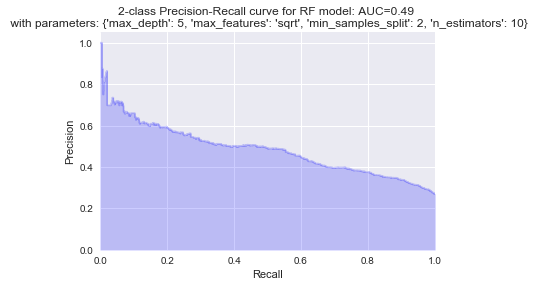

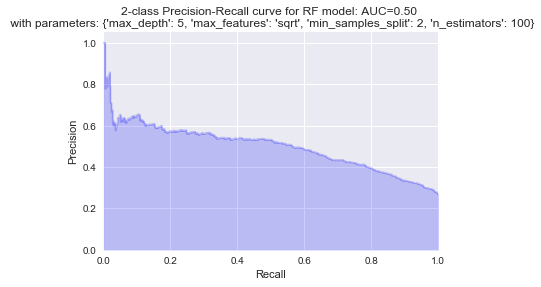

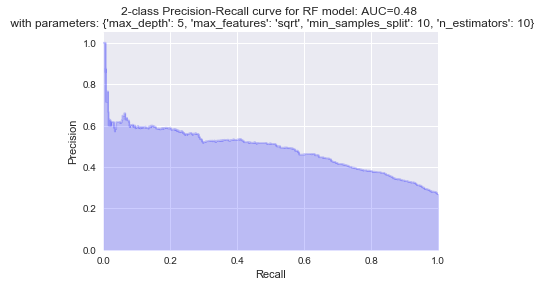

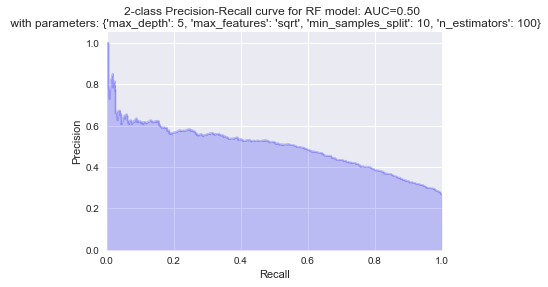

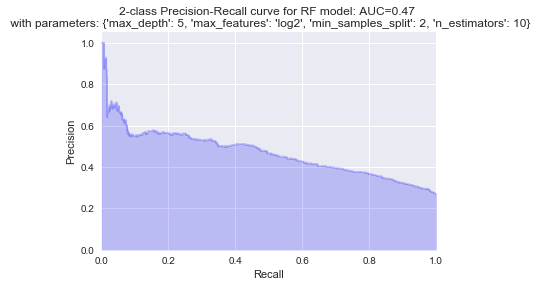

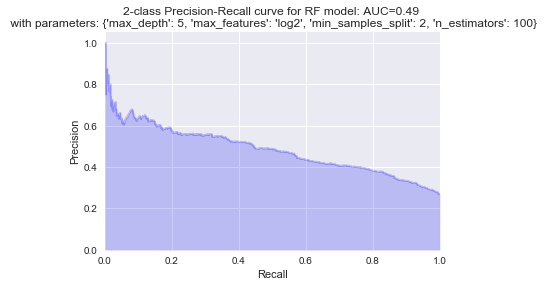

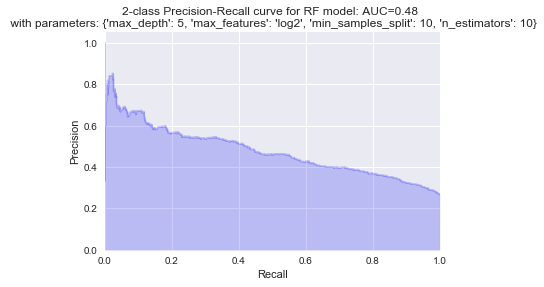

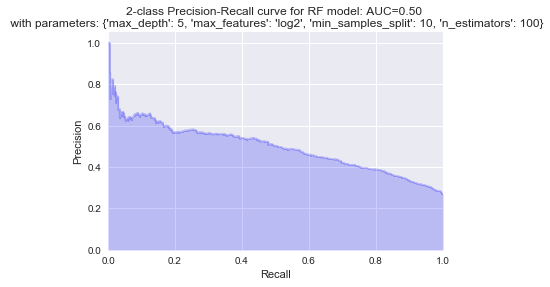

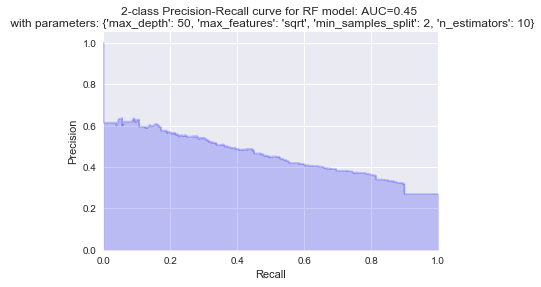

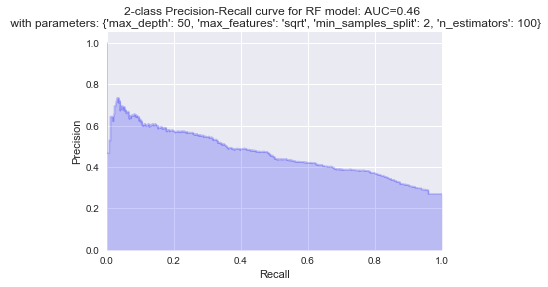

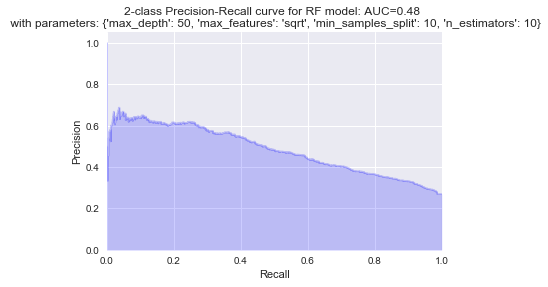

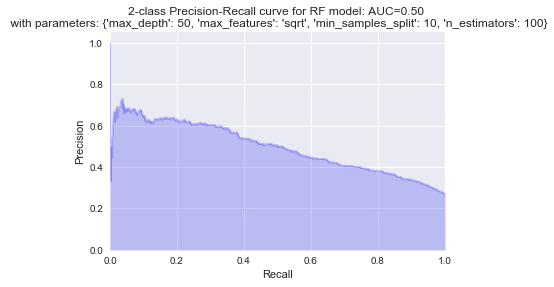

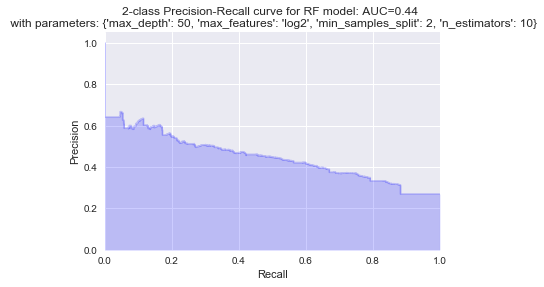

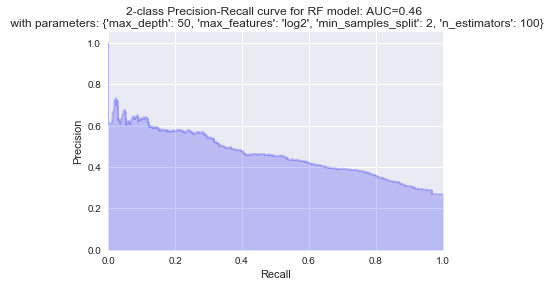

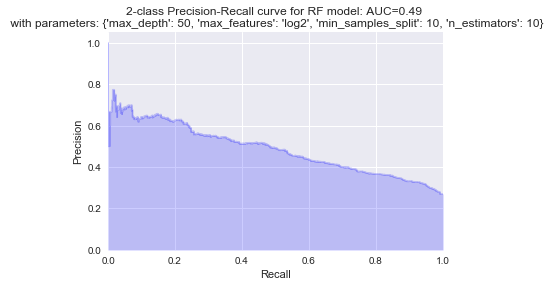

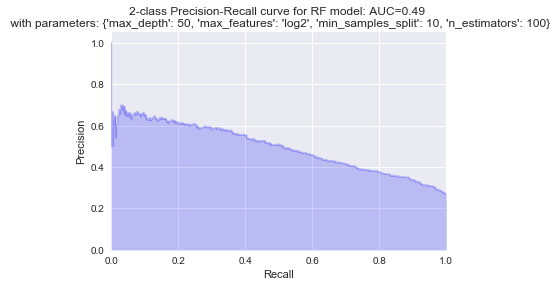

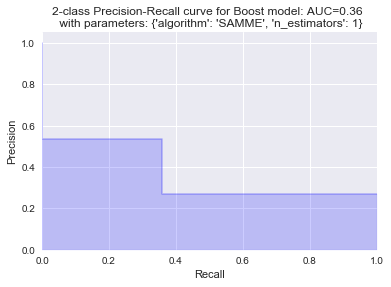

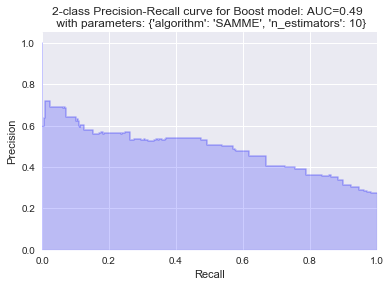

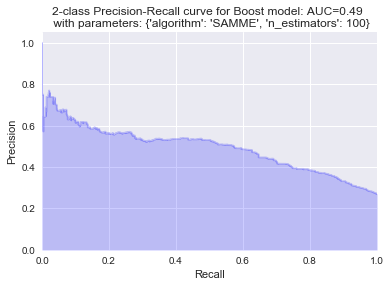

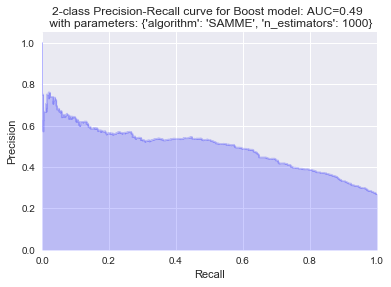

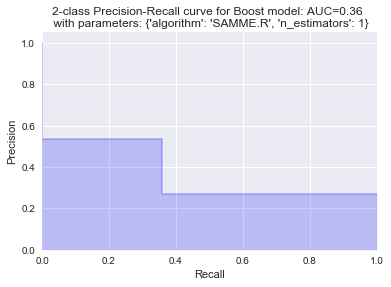

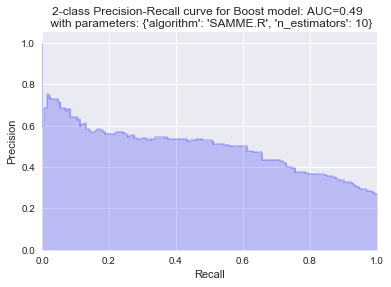

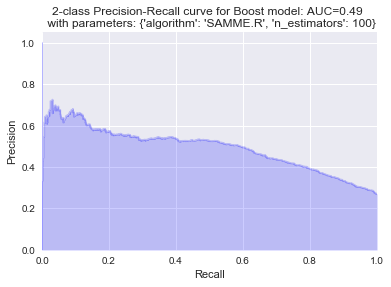

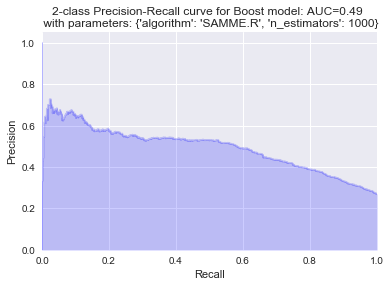

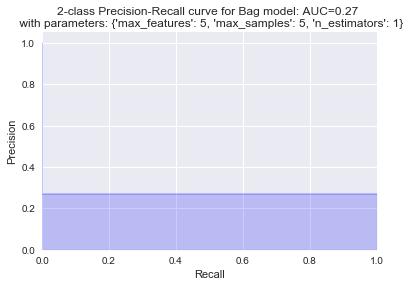

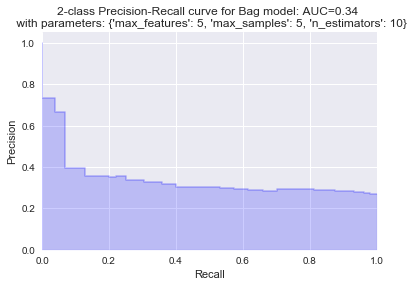

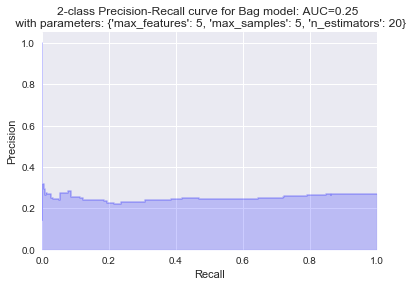

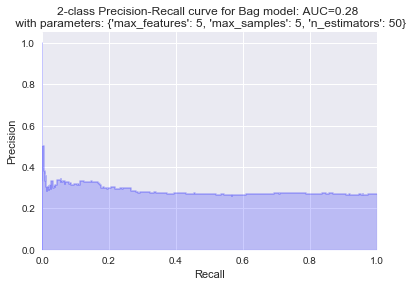

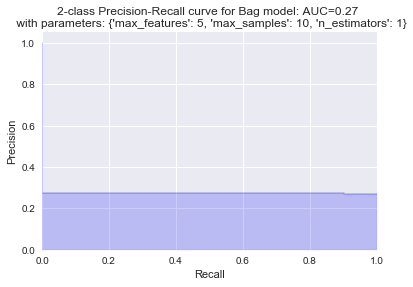

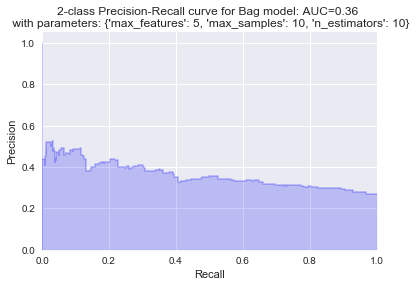

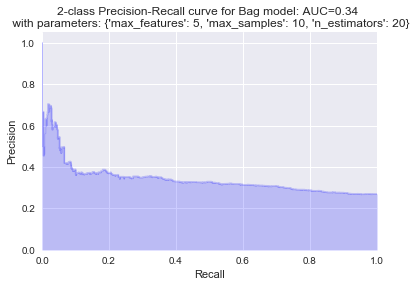

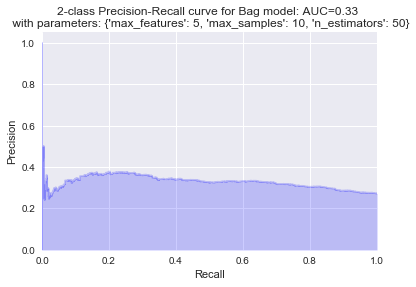

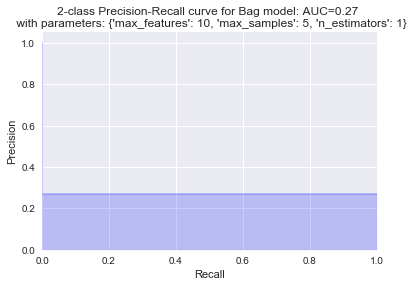

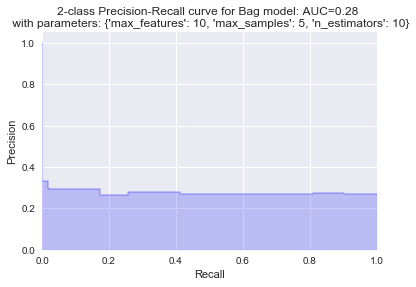

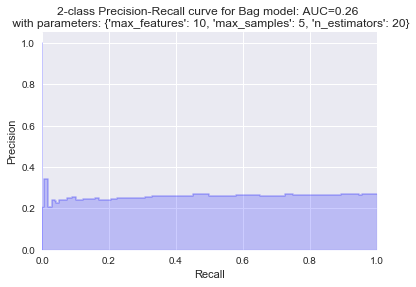

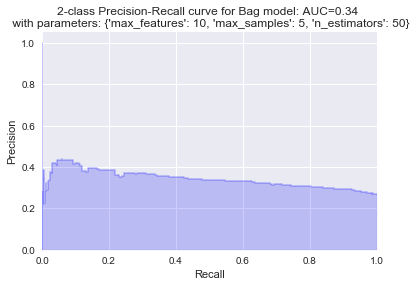

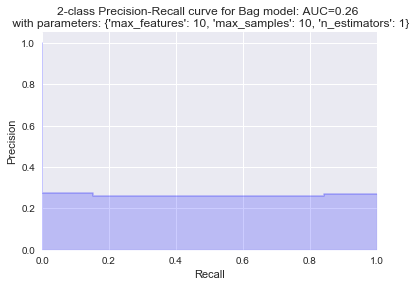

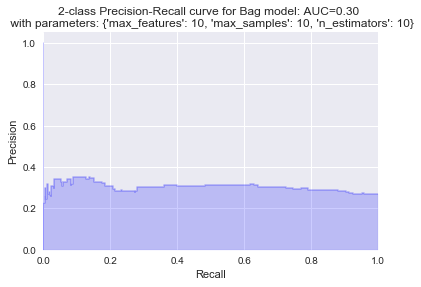

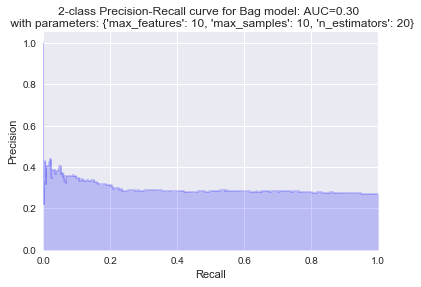

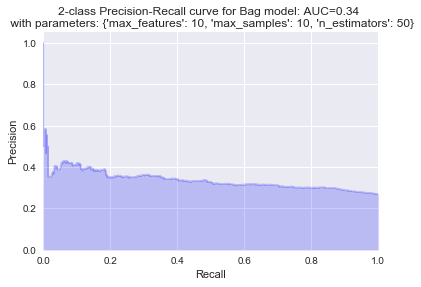

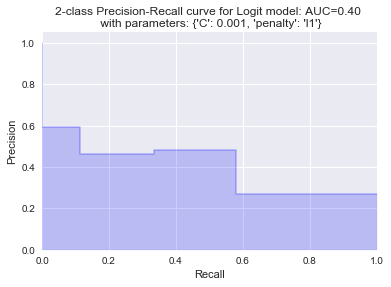

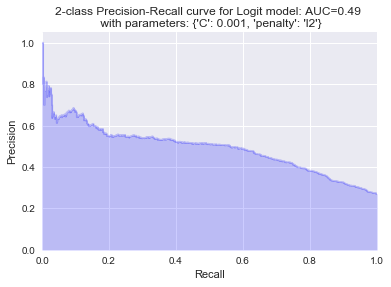

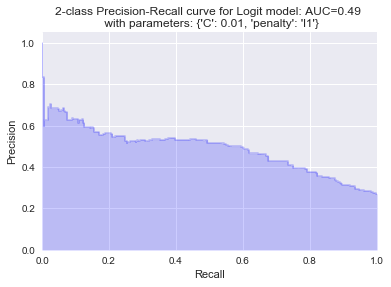

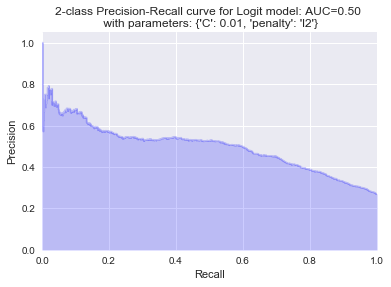

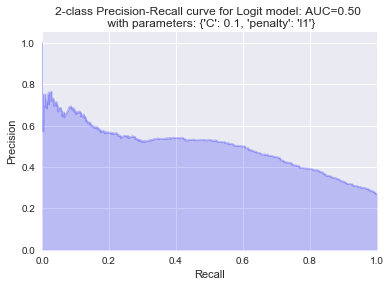

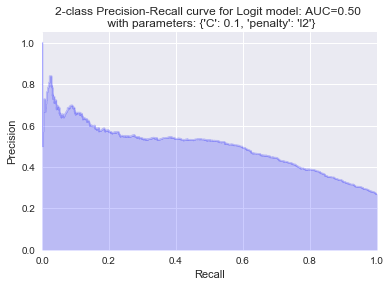

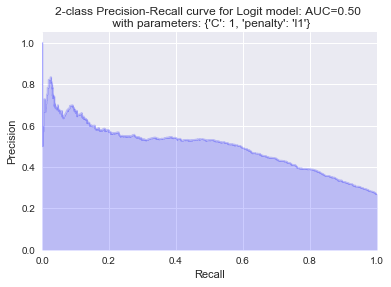

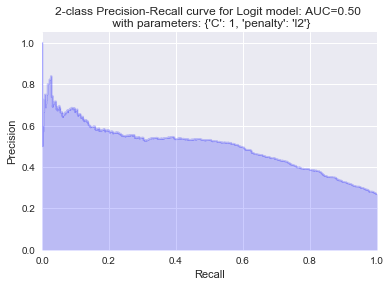

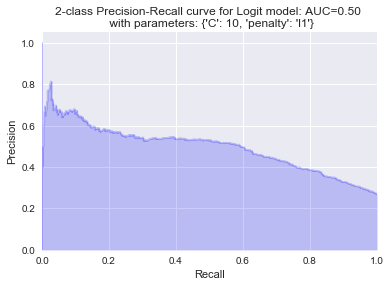

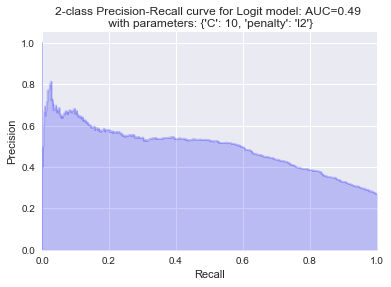

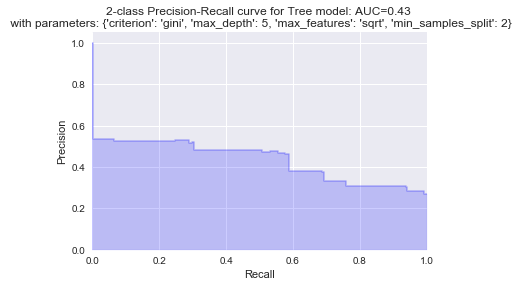

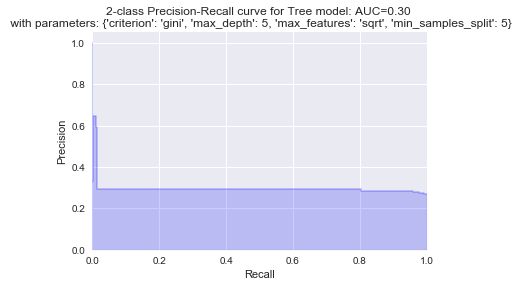

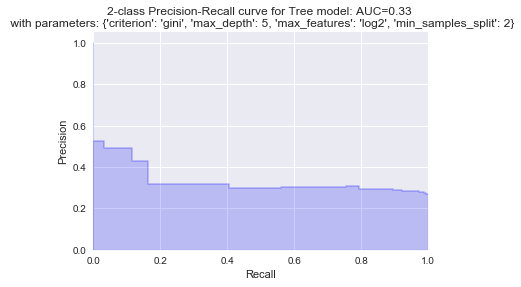

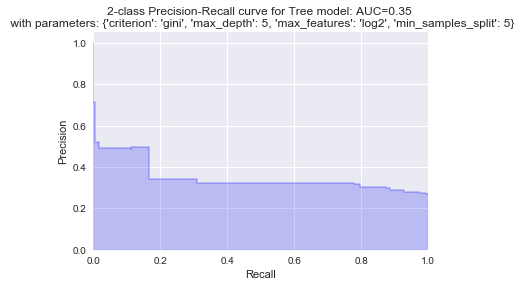

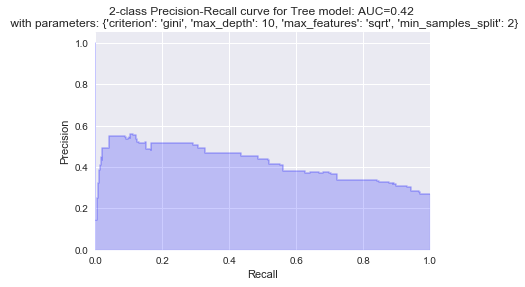

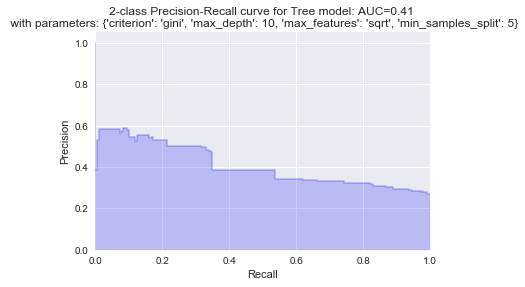

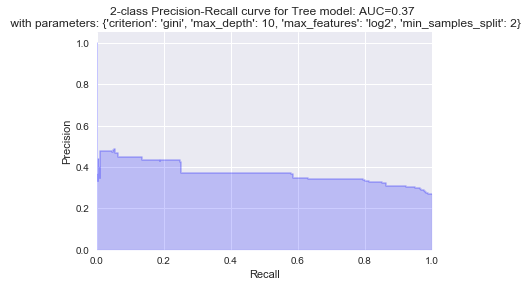

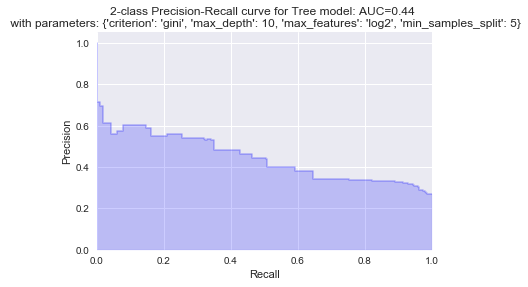

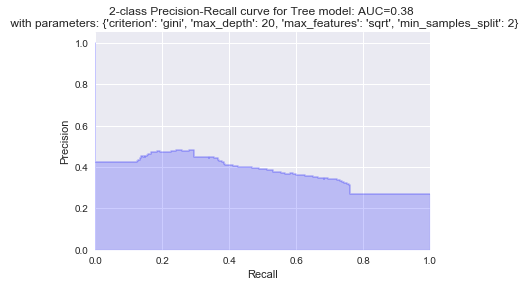

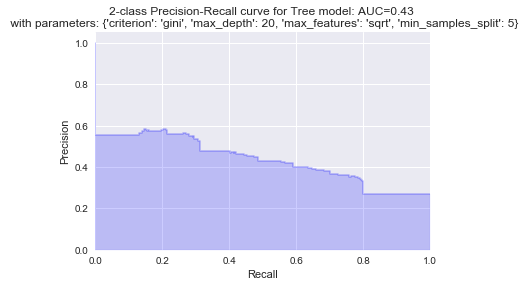

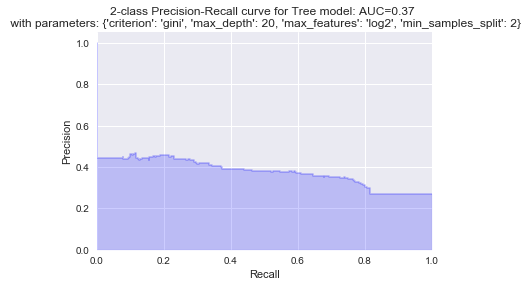

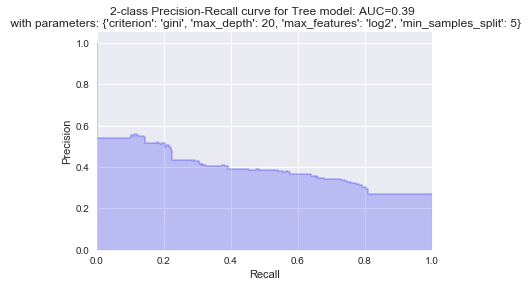

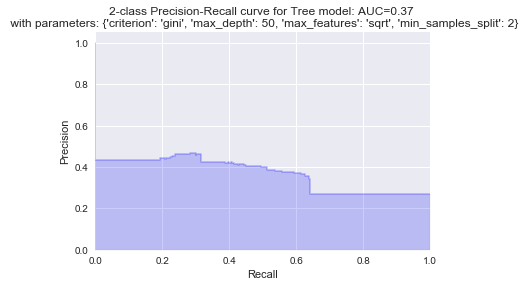

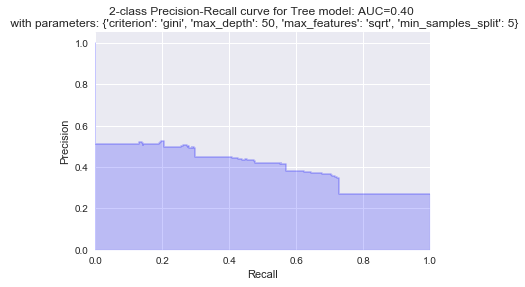

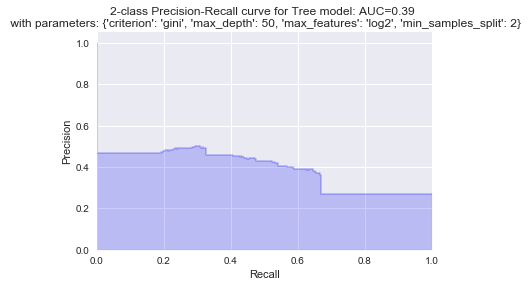

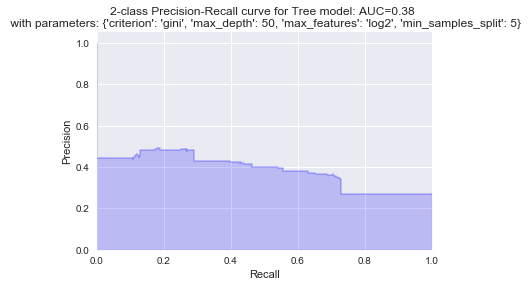

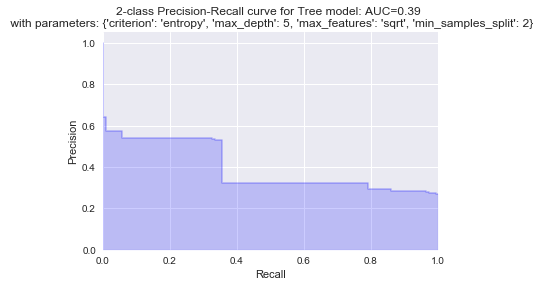

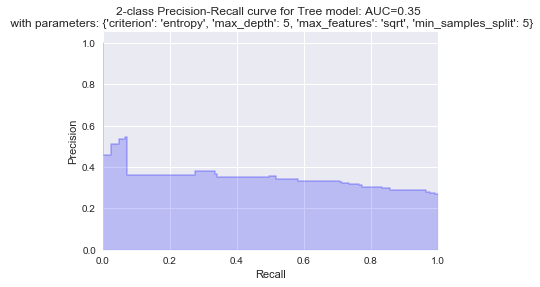

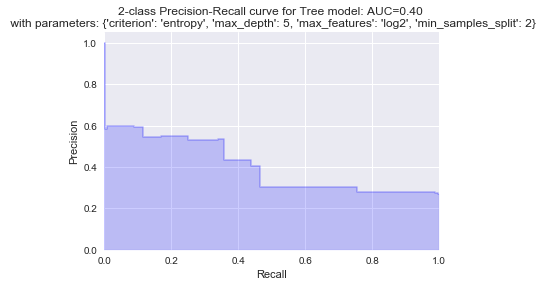

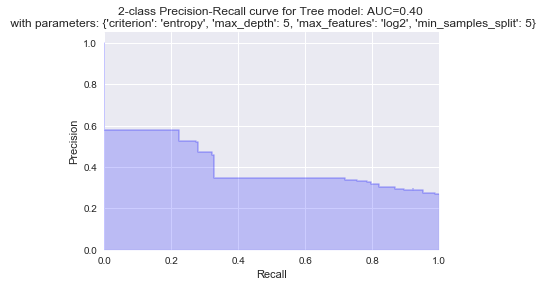

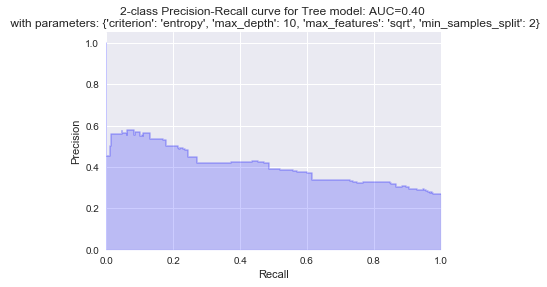

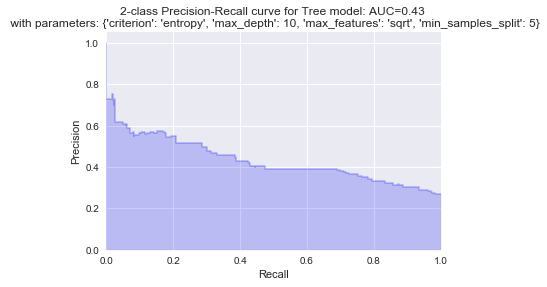

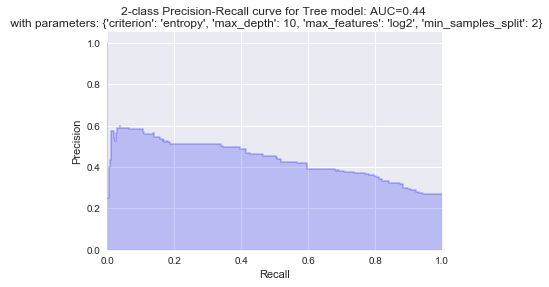

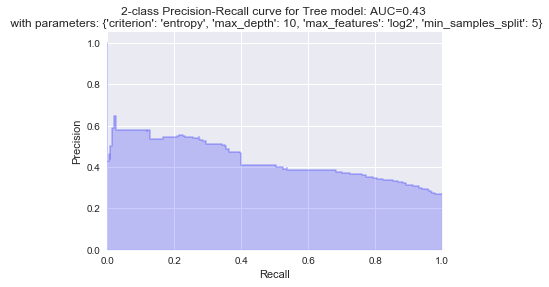

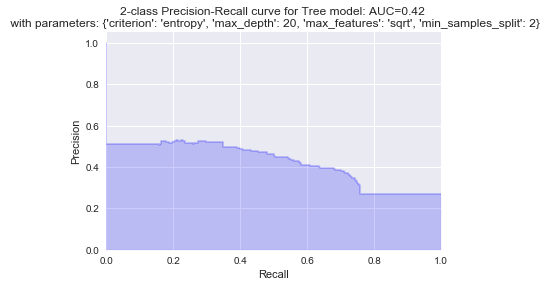

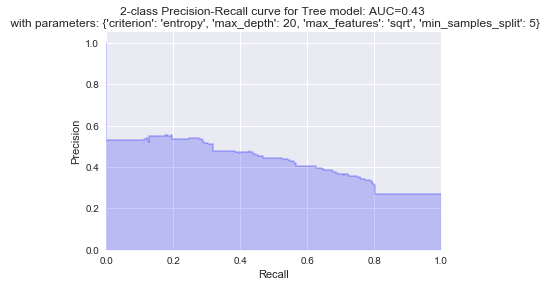

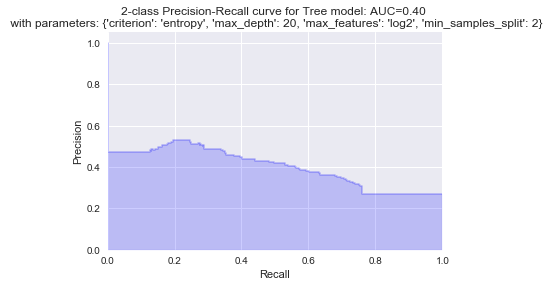

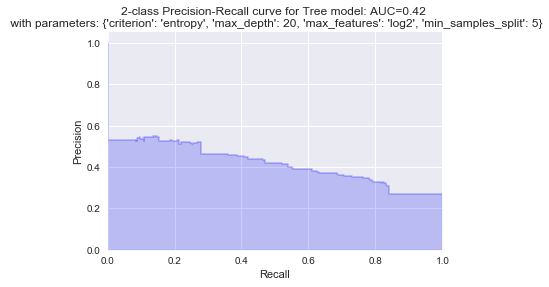

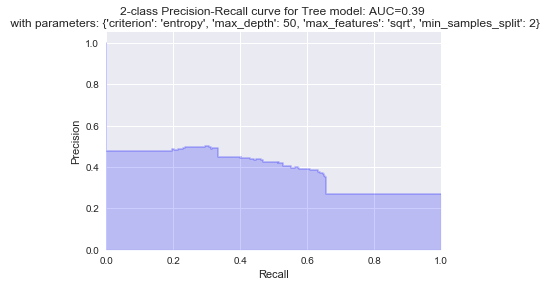

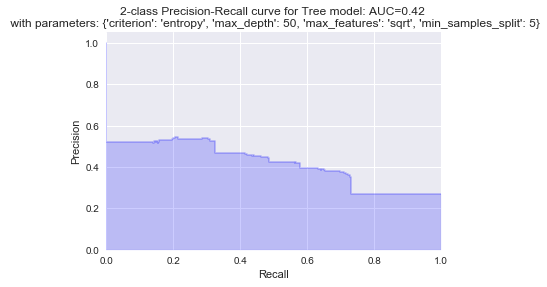

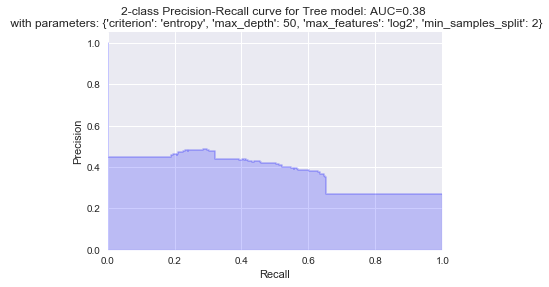

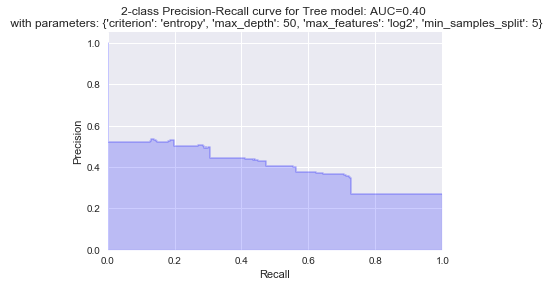

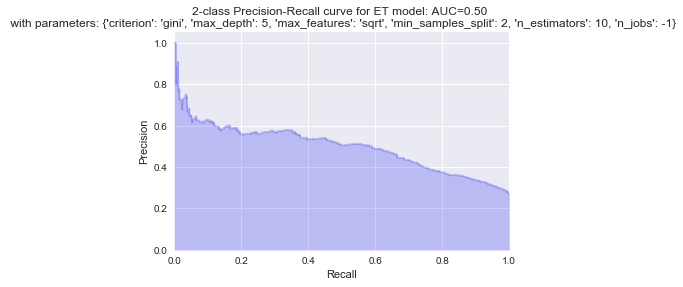

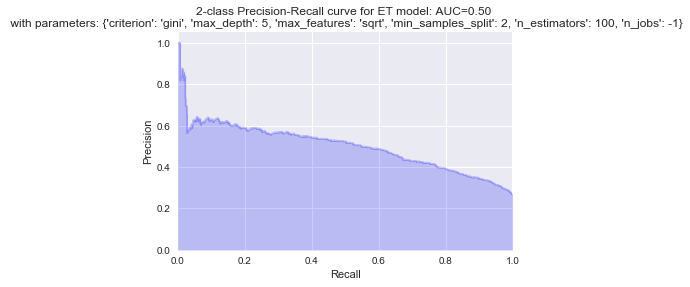

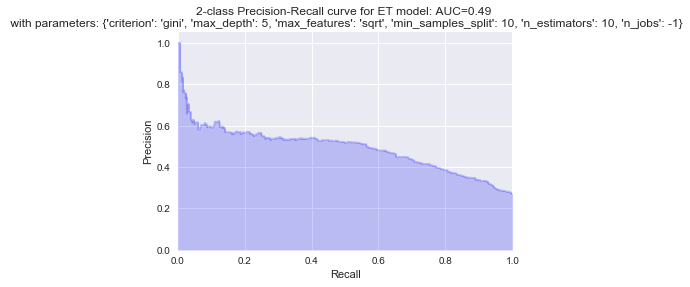

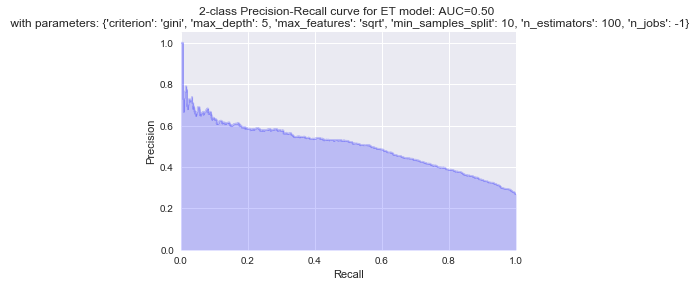

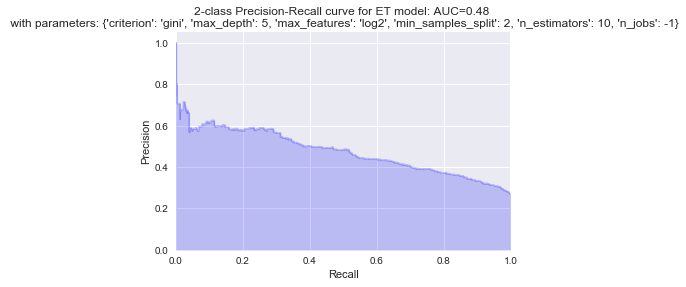

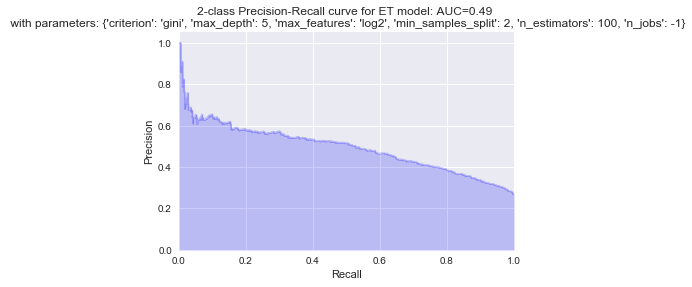

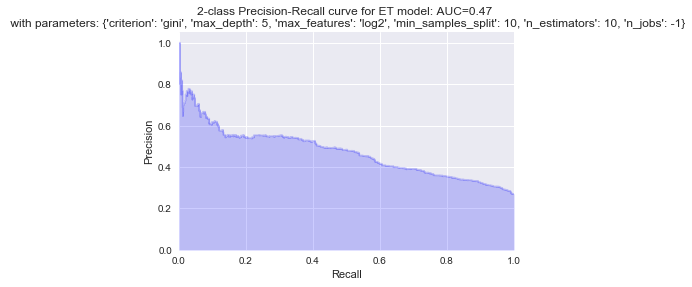

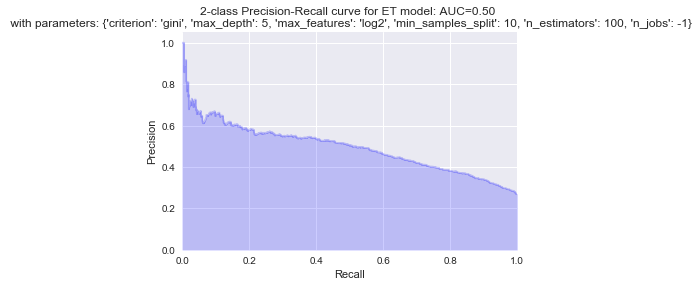

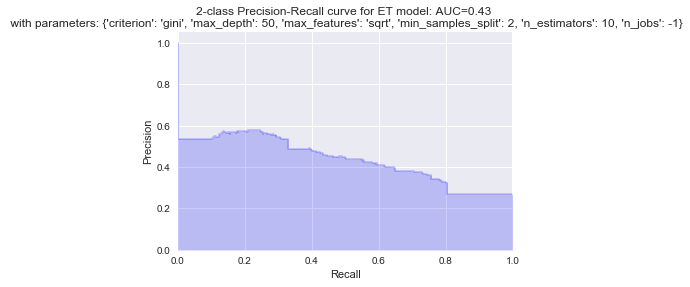

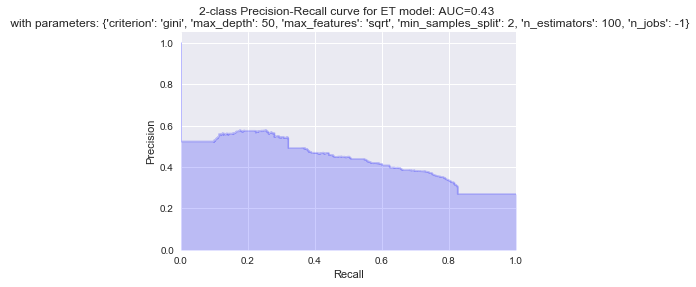

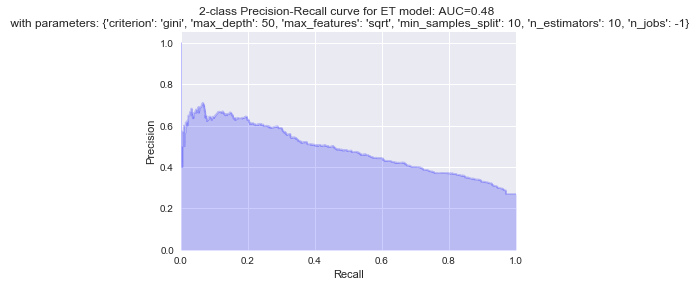

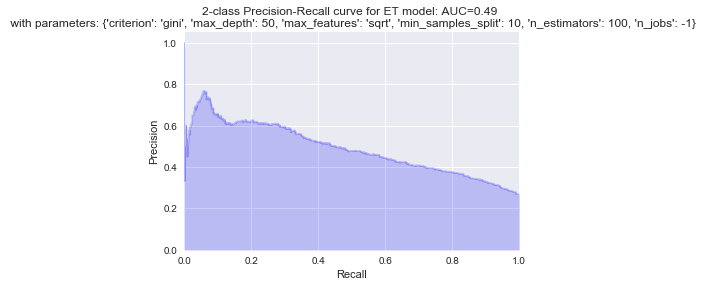

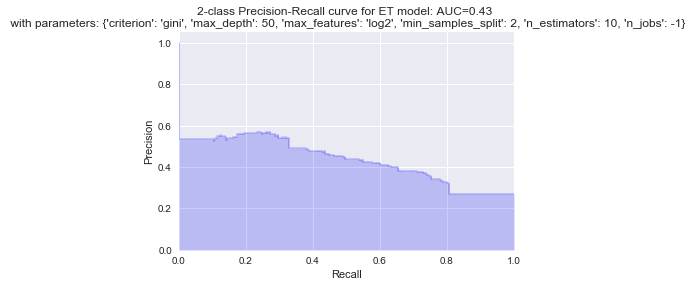

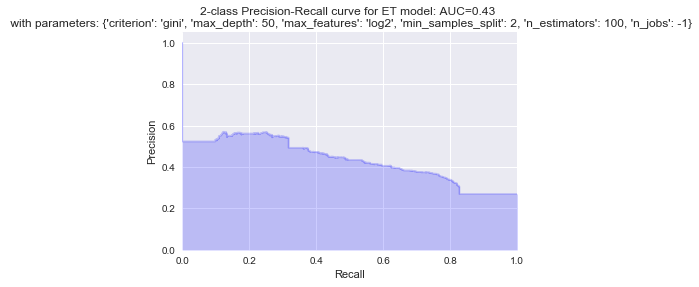

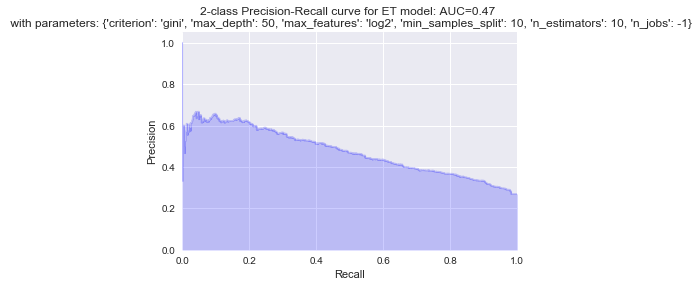

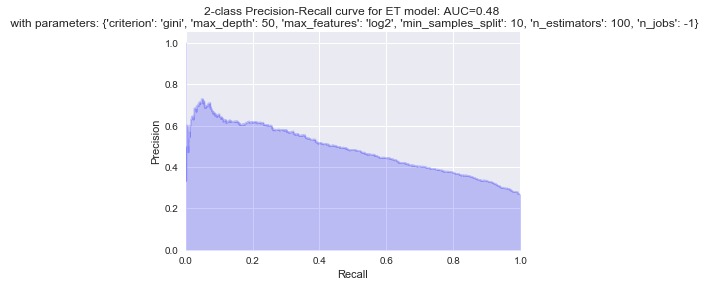

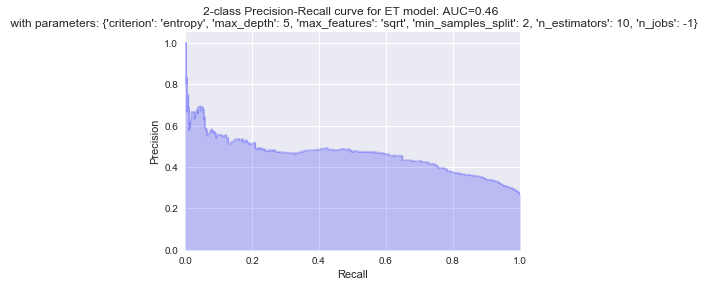

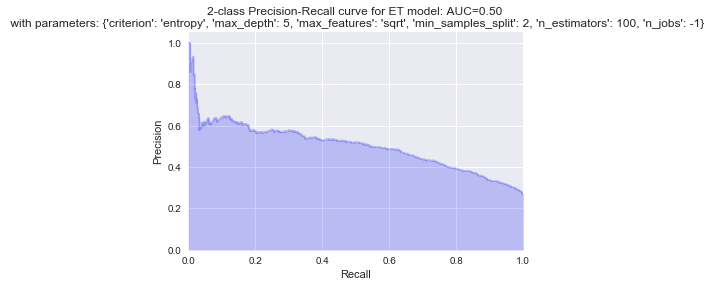

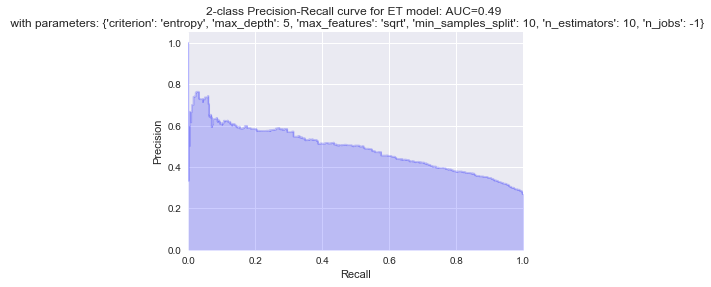

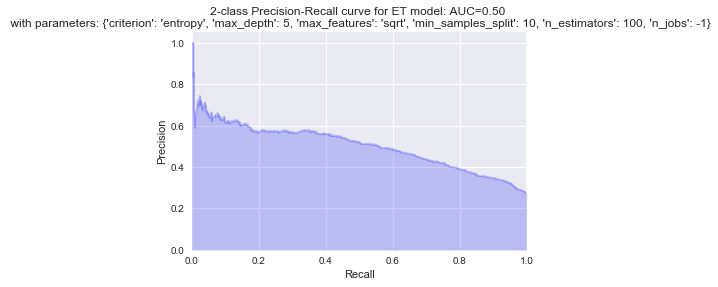

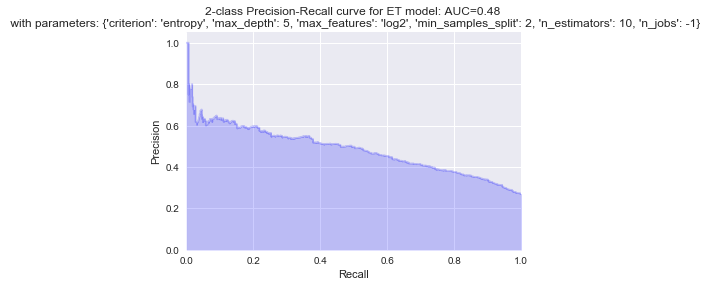

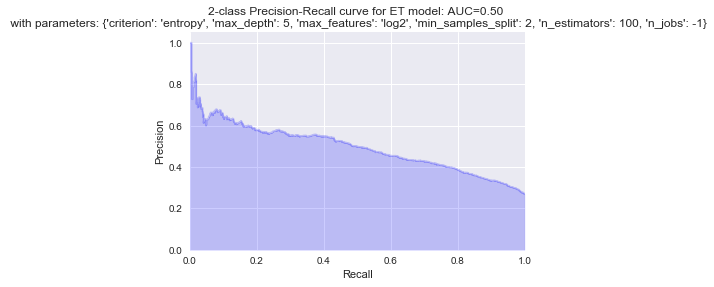

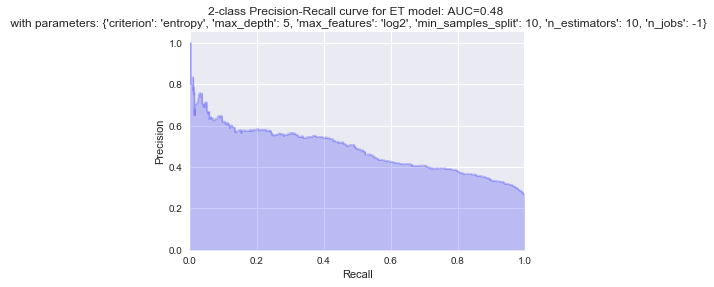

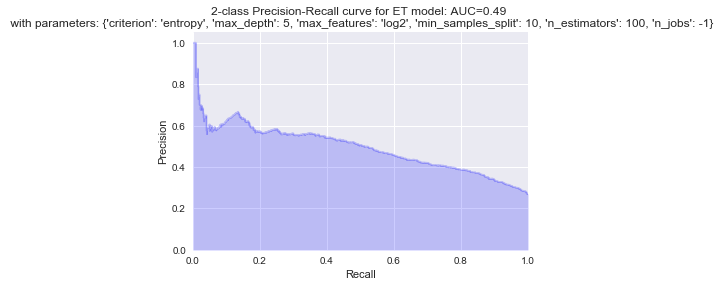

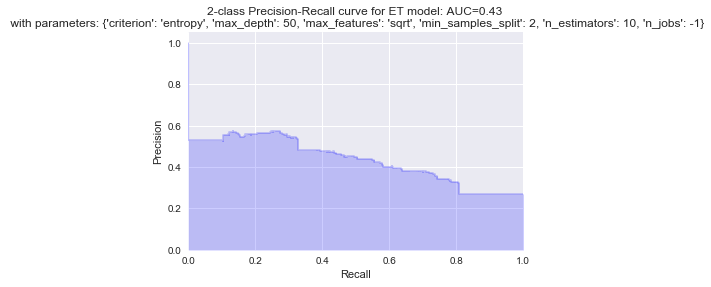

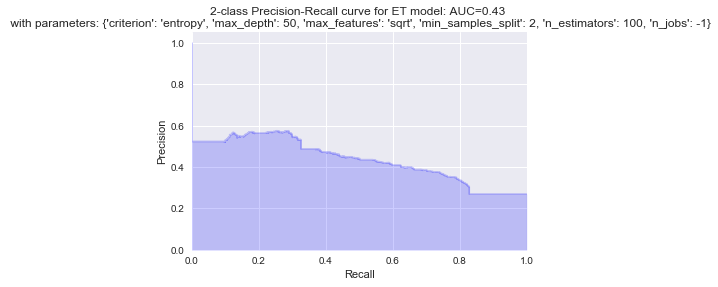

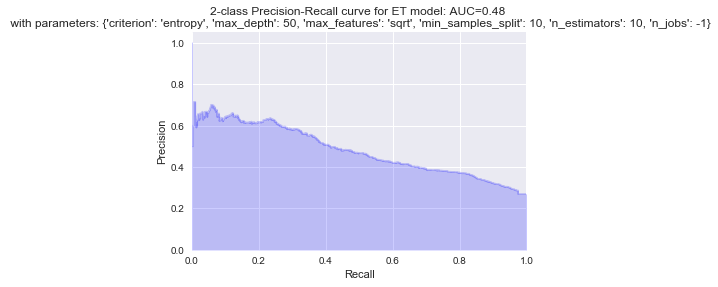

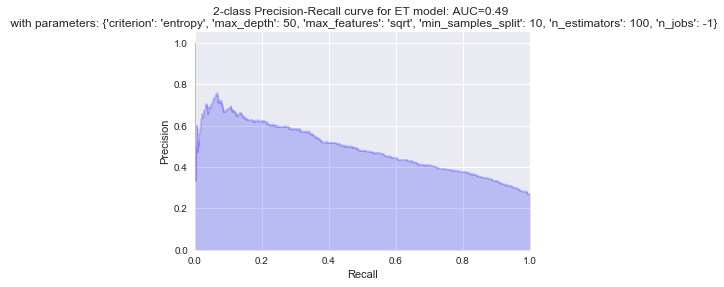

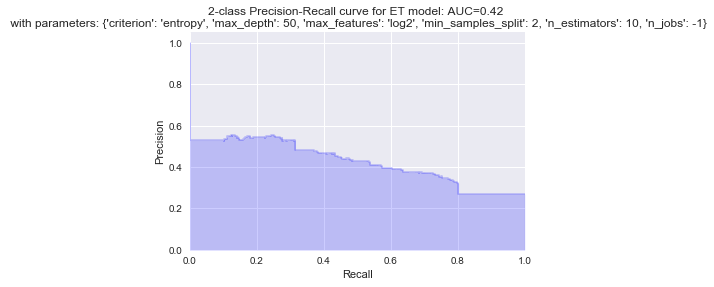

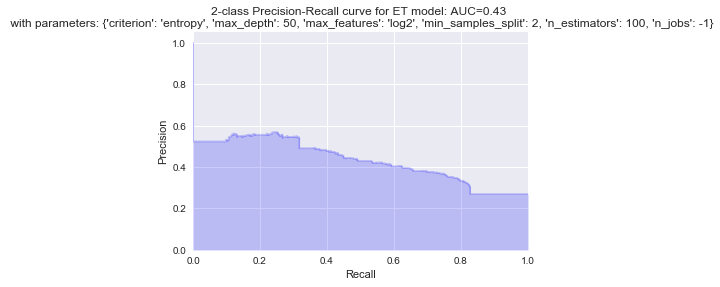

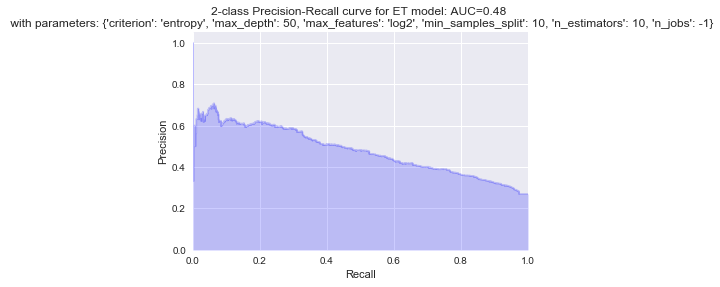

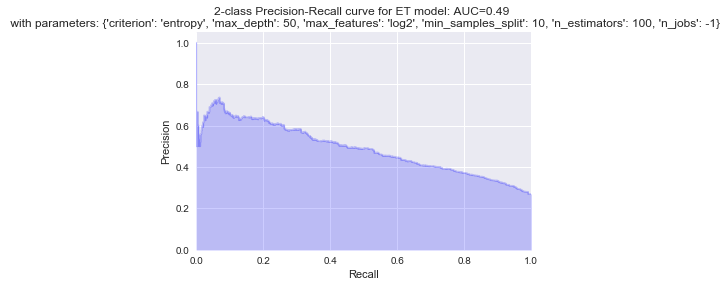

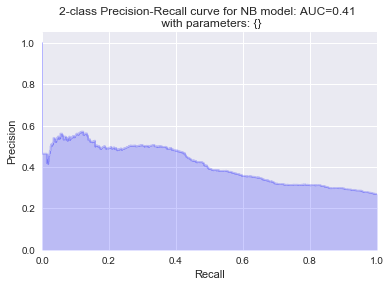

In [99]:
results2 = clf_loop(["RF", "Boost", "Bag", "Logit", "Tree",  "ET", "NB"], x_train, x_test, y_train2, y_test2)

In [100]:
from IPython.display import display
display(results2)

model_type                                         parameters  accuracy  \
0           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7308   
1           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7379   
2           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7332   
3           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7399   
4           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...    0.7329   
5           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...    0.7311   
6           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...    0.7329   
7           RF  {'max_depth': 5, 'max_features': 'log2', 'min_...    0.7323   
8           RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...    0.7341   
9           RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...    0.7350   
10          RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...    0.7505   
11          RF  {'max_depth': 50, 'max_features': 'sqrt', 'min...    0.7602   
12          RF  {'max_depth': 50, 'max_features': 'log2', 'min...    0.7314   
13          RF  {'max_depth': 50, 'max_features': 'log2', 'min...    0.7367   
14          RF  {'max_depth': 50, 'max_features': 'log2', 'min...    0.7461   
15          RF  {'max_depth': 50, 'max_features': 'log2', 'min...    0.7543   
16       Boost          {'algorithm': 'SAMME', 'n_estimators': 1}    0.7432   
17       Boost         {'algorithm': 'SAMME', 'n_estimators': 10}    0.7423   
18       Boost        {'algorithm': 'SAMME', 'n_estimators': 100}    0.7435   
19       Boost       {'algorithm': 'SAMME', 'n_estimators': 1000}    0.7411   
20       Boost        {'algorithm': 'SAMME.R', 'n_estimators': 1}    0.7432   
21       Boost       {'algorithm': 'SAMME.R', 'n_estimators': 10}    0.7420   
22       Boost      {'algorithm': 'SAMME.R', 'n_estimators': 100}    0.7432   
23       Boost     {'algorithm': 'SAMME.R', 'n_estimators': 1000}    0.7435   
24         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...    0.7308   
25         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...    0.6085   
26         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...    0.7308   
27         Bag  {'max_features': 5, 'max_samples': 5, 'n_estim...    0.7308   
28         Bag  {'max_features': 5, 'max_samples': 10, 'n_esti...    0.7308   
29         Bag  {'max_features': 5, 'max_samples': 10, 'n_esti...    0.7294   
..         ...                                                ...       ...   
85          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7411   
86          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7329   
87          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7323   
88          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7314   
89          ET  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7323   
90          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7411   
91          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7426   
92          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7479   
93          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7529   
94          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7435   
95          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7435   
96          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7485   
97          ET  {'criterion': 'gini', 'max_depth': 50, 'max_fe...    0.7526   
98          ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7326   
99          ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7353   
100         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7373   
101         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7405   
102         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7364   
103         ET  {'criterion': 'entropy', 'max_depth': 

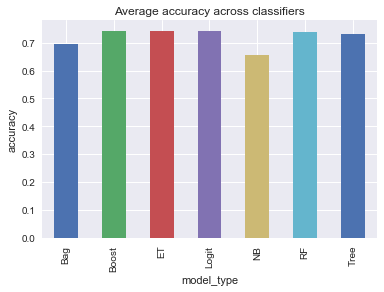

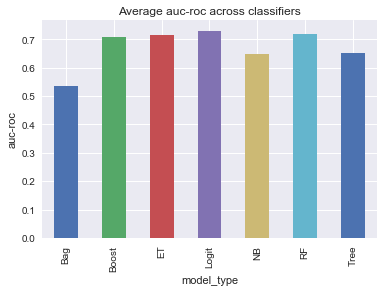

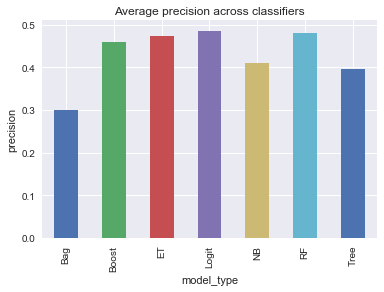

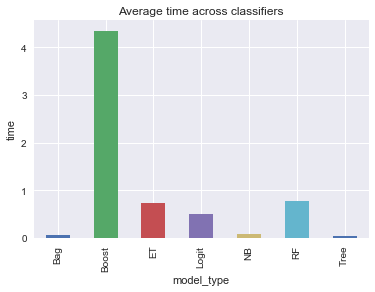

In [101]:
for item in ['accuracy', 'auc-roc','precision','time']:
    plt.figure()
    results2.groupby(['model_type'])[item].mean().plot(kind='bar', title='Average '+item+' across classifiers')
    plt.ylabel(item)

In [102]:
models2 =results2.groupby('model_type')['auc-roc'].nlargest(1)

In [103]:
models2

model_type     
Bag         29     0.6124
Boost       22     0.7394
ET          101    0.7460
Logit       44     0.7390
NB          114    0.6491
RF          1      0.7418
Tree        50     0.6940
Name: auc-roc, dtype: float64

In [104]:
rows2 = [29,22,101,44,114,1,50]

In [105]:
results2.loc[rows2].iloc[:,0:6]

model_type                                         parameters  accuracy  \
29         Bag  {'max_features': 5, 'max_samples': 10, 'n_esti...    0.7294   
22       Boost      {'algorithm': 'SAMME.R', 'n_estimators': 100}    0.7432   
101         ET  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.7405   
44       Logit                        {'C': 0.1, 'penalty': 'l1'}    0.7405   
114         NB                                                 {}    0.6575   
1           RF  {'max_depth': 5, 'max_features': 'sqrt', 'min_...    0.7379   
50        Tree  {'criterion': 'gini', 'max_depth': 5, 'max_fea...    0.7394   

     auc-roc  precision    time  
29    0.6124     0.3598  0.0328  
22    0.7394     0.4926  1.5886  
101   0.7460     0.5030  0.6120  
44    0.7390     0.4977  0.4614  
114   0.6491     0.4099  0.0895  
1     0.7418     0.4985  0.6615  
50    0.6940     0.4320  0.0247

In [111]:
best2 = {}
for row in rows2:
    best2[results2.loc[row]["model_type"]]=results2.loc[row]["parameters"]

In [112]:
for k,arg in best2.items():
    for key,val in arg.items():
        arg[key] = [val]

In [113]:
best2

{'Bag': {'max_features': [5], 'max_samples': [10], 'n_estimators': [10]},
 'Boost': {'algorithm': ['SAMME.R'], 'n_estimators': [100]},
 'ET': {'criterion': ['entropy'],
  'max_depth': [5],
  'max_features': ['sqrt'],
  'min_samples_split': [10],
  'n_estimators': [100],
  'n_jobs': [-1]},
 'Logit': {'C': [0.1], 'penalty': ['l1']},
 'NB': {},
 'RF': {'max_depth': [5],
  'max_features': ['sqrt'],
  'min_samples_split': [2],
  'n_estimators': [100]},
 'Tree': {'criterion': ['gini'],
  'max_depth': [5],
  'max_features': ['sqrt'],
  'min_samples_split': [2]}}

In [ ]:
results2.loc[55]['parameters']

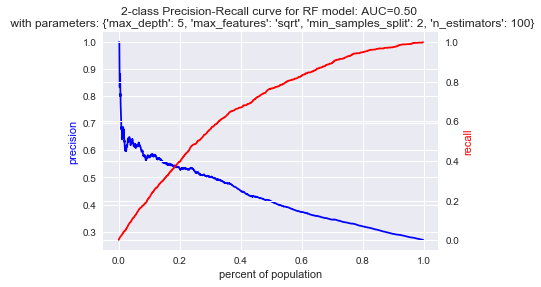

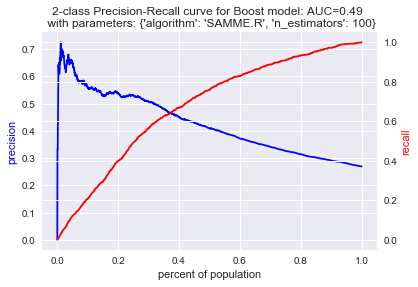

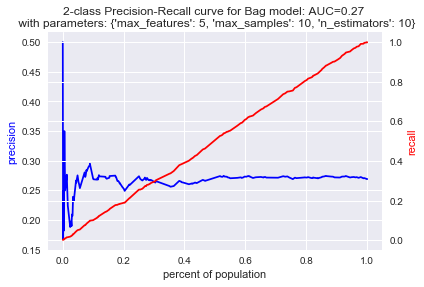

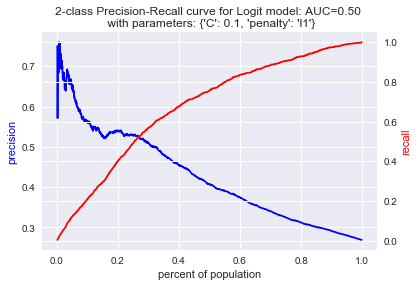

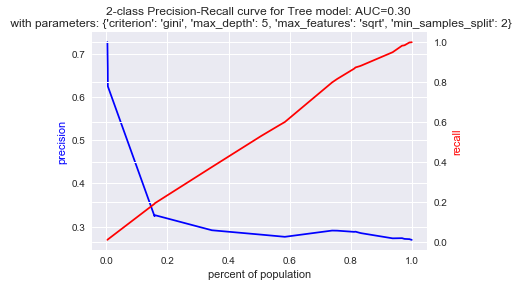

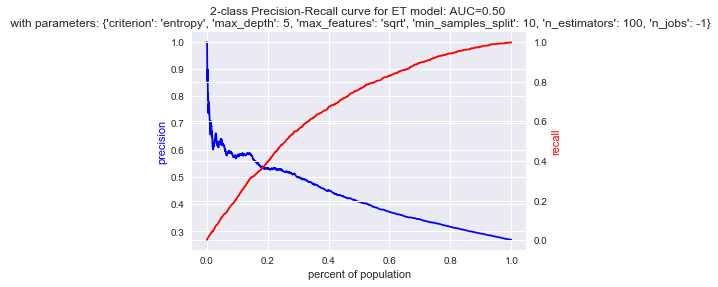

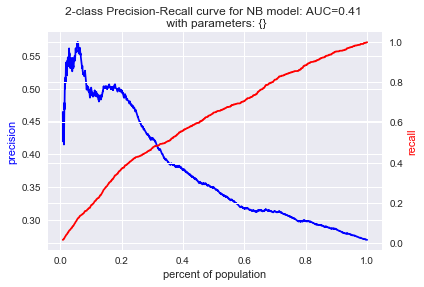

In [114]:
plot_best(["RF", "Boost", "Bag", "Logit", "Tree",  "ET", "NB"], x_train, x_test, y_train2, y_test2, best2)

In [ ]:
#Printing out the best decision tree
dt = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features='sqrt', min_samples_split=5)

In [ ]:
tree = dt.fit(x_train, y_train2)

In [ ]:
tree_viz = export_graphviz(tree, out_file=None, feature_names=indepv, rounded=True, filled=True)
graph =graphviz.Source(tree_viz)

In [ ]:
graph

Feature ranking:
2. mh_treatment (0.062562)
1. bailed_out (0.236313)
49. bail_typeSUR (0.003677)
17. case_typeCR (0.014438)
4. sexMALE (0.028928)
3. sexFEMALE (0.032945)
32. arresting_agencyOVERLAND PARK P.D. (0.007457)
7. raceBLACK OR AFRICAN AMERICAN (0.023960)
8. raceWHITE (0.023529)
13. mar_statS (0.022193)
18. case_typeDV (0.013494)
48. bail_typePR (0.003770)
30. arresting_agencyOLATHE P.D. (0.008043)
19. case_typeJV (0.012530)
11. mar_statM (0.023042)
10. mar_statD (0.023194)
27. arresting_agencyLENEXA P.D. (0.009066)
36. arresting_agencySHAWNEE P.D. (0.007318)
51. per_capita_income_binned1 (0.003540)
81. own_children_under18_binned1 (0.001293)
39. arresting_agency_typeCITY (0.006027)
23. arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT (0.011900)
41. arresting_agency_typeCOUNTY SHERIFF (0.005801)
50. per_capita_income_binned0 (0.003621)
28. arresting_agencyMERRIAM P.D. (0.008994)
45. bail_typeCA (0.004521)
80. own_children_under18_binned0 (0.001299)
47. bail_typeORCD (0.00394

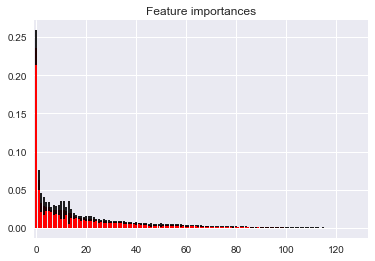

In [115]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in indices:
    print("%d. %s (%f)" % (f + 1, indepv[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xlim([-1, x_train.shape[1]])
plt.show()

Feature ranking:
2. mh_treatment (0.066425)
1. bailed_out (0.219614)
49. bail_typeSUR (0.003823)
17. case_typeCR (0.014660)
4. sexMALE (0.027902)
3. sexFEMALE (0.037248)
13. mar_statS (0.021480)
48. bail_typePR (0.003866)
8. raceWHITE (0.025053)
7. raceBLACK OR AFRICAN AMERICAN (0.025215)
32. arresting_agencyOVERLAND PARK P.D. (0.007832)
18. case_typeDV (0.014158)
30. arresting_agencyOLATHE P.D. (0.008576)
11. mar_statM (0.024554)
10. mar_statD (0.024807)
27. arresting_agencyLENEXA P.D. (0.009466)
19. case_typeJV (0.012833)
36. arresting_agencySHAWNEE P.D. (0.007152)
51. per_capita_income_binned1 (0.003530)
81. own_children_under18_binned1 (0.001262)
41. arresting_agency_typeCOUNTY SHERIFF (0.005827)
39. arresting_agency_typeCITY (0.005999)
23. arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT (0.011802)
50. per_capita_income_binned0 (0.003542)
28. arresting_agencyMERRIAM P.D. (0.009033)
45. bail_typeCA (0.004472)
47. bail_typeORCD (0.003918)
80. own_children_under18_binned0 (0.00129

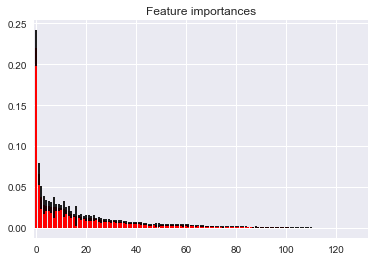

In [116]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train2)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in indices:
    print("%d. %s (%f)" % (f + 1, indepv[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [ ]:
indepv